#  Inflation as equity trading signal

This notebook serves as an illustration of the points discussed in the post ["Inflation as equity trading signal"](https://research.macrosynergy.com/cpi-dynamics-as-equity-trading-signal/) available on the Macrosynergy website. 

Academic research suggests that high and rising consumer price inflation puts upward pressure on real discount rates and is a headwind for equity market performance. A fresh analysis of 17 international markets since 2000 confirms an ongoing pervasive negative relation between published CPI dynamics and subsequent equity returns. Global equity index portfolios that have respected the inflation dynamics of major currency areas significantly outperformed equally weighted portfolios. Even the simplest metrics have served well as warning signals at the outset of large market drawdowns and as heads-ups for opportunities before recoveries. The evident predictive power of inflation for country equity indices has broad implications for the use of real-time CPI metrics in equity portfolio management.

This notebook provides the essential code required to replicate the analysis discussed in the post.  

The notebook covers the three main parts:

- __Get Packages and JPMaQS Data:__ This section is responsible for installing and importing the necessary Python packages that are used throughout the analysis. 

- __Transformations and Checks:__ In this part, the notebook performs various calculations and transformations on the data to derive the relevant signals and targets used for the analysis, including excess inflation indicators, effective excess inflation, relative excess inflation, and other metrics or ratios used in the analysis.

- __Value Checks:__ This is the most critical section, where the notebook calculates and implements the trading strategies based on the hypotheses tested in the post. Depending on the analysis, this section involves backtesting two simple inflation-based trading strategies targeting equity returns.

It's important to note that while the notebook covers a selection of indicators and strategies used for the post's main findings, there are countless other possible indicators and approaches that can be explored by users, as mentioned in the post. Users can modify the code to test different hypotheses and strategies based on their own research and ideas. Best of luck with your research!

## Get packages and JPMaQS data

This notebook primarily relies on the standard packages available in the Python data science stack. However, there is an additional package [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) that is required for two purposes:

- Downloading JPMaQS data: The [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package facilitates the retrieval of JPMaQS data, which is used in the notebook.

- For the analysis of quantamental data and value propositions: The [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package provides functionality for performing quick analyses of quantamental data and exploring value propositions.

For detailed information and a comprehensive understanding of the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package and its functionalities, please refer to the [“Introduction to Macrosynergy package”](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php) notebook on the Macrosynergy Quantamental Academy.

In [1]:
import numpy as np
import pandas as pd
import os
import itertools

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn
import macrosynergy.visuals as msv

from macrosynergy.management.utils import merge_categories

from macrosynergy.download import JPMaQSDownload

import warnings
warnings.simplefilter("ignore")

The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real-time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md).

In [2]:
# DM equity currency areas
cids_g3eq = ["EUR", "JPY", "USD"]
cids_dmeq_xg3 = ["AUD", "CAD", "CHF", "GBP", "SEK"]
cids_dmeq = cids_g3eq + cids_dmeq_xg3

# EM equity currency areas (ex Turkey)
cids_emeq = ["BRL", "INR", "KRW", "MXN", "MYR", "SGD", "THB", "TWD", "ZAR"]


cids_eq = cids_dmeq + cids_emeq
cids_eq.sort()
cids = cids_eq

# Countries with earlyinflation data
cids_early = ["GBP", "JPY", "USD", "ZAR", "SGD", "MXN"]

In [3]:
# Standard CPI categories
main = [
    "CPIH_SA_P1M1ML12",
    "CPIH_SJA_P3M3ML3AR",
    "CPIH_SJA_P6M6ML6AR",
    "CPIH_SA_P1M1ML12_D1M1ML3",
    "CPIC_SA_P1M1ML12",
    "CPIC_SJA_P3M3ML3AR",
    "CPIC_SJA_P6M6ML6AR",
    "CPIC_SA_P1M1ML12_D1M1ML3"
]

# CPI categories using early information
early = ["CPIHE_SA_P1M1ML12", 
         "CPIHE_SJA_P3M3ML3AR", 
         "CPIHE_SJA_P6M6ML6AR", 
         "CPIHE_SA_P1M1ML12_D1M1ML3",
         "CPICE_SA_P1M1ML12", 
         "CPICE_SJA_P3M3ML3AR", 
         "CPICE_SJA_P6M6ML6AR", 
         "CPICE_SA_P1M1ML12_D1M1ML3"]

# Extra categories
xtra = ["INFTEFF_NSA",
        "INFTARGET_NSA",
        "USDGDPWGT_SA_3YMA"]

# Target returns
rets = [
    "EQXR_NSA",
    "EQXR_VT10",
]

xcats = main + xtra + rets + early

# Resultant tickers

tickers = [cid + "_" + xcat for cid in cids for xcat in xcats]
print(f"Maximum number of tickers is {len(tickers)}")

Maximum number of tickers is 357


JPMaQS indicators are conveniently grouped into 6 main categories: Economic Trends, Macroeconomic balance sheets, Financial conditions, Shocks and risk measures, Stylized trading factors, and Generic returns. Each indicator has a separate page with notes, description, availability, statistical measures, and timelines for main currencies. The description of each JPMaQS category is available under [Macro quantamental academy](https://academy.macrosynergy.com/quantamental-indicators/). For tickers used in this notebook see [Consumer price inflation trends](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Consumer%20price%20inflation%20trends.php),  [Inflation targets](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Inflation%20targets.php), [Global production shares](https://macrosynergy.com/academy/notebooks/shares-in-global-production/), and [Equity index future returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Equity%20index%20future%20returns.php).

In [4]:
# Download series from J.P. Morgan DataQuery by tickers

start_date = "1990-01-01"
tickers = [cid + "_" + xcat for cid in cids for xcat in xcats]
print(f"Maximum number of tickers is {len(tickers)}")

# Retrieve credentials

client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

# Download from DataQuery

with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as downloader:

    df = downloader.download(
        tickers=tickers,
        start_date=start_date,
        metrics=["value"],
        suppress_warning=True,
        show_progress=True,
       
    )

dfx= df.copy()

Maximum number of tickers is 357
Timestamp UTC:  2025-03-05 15:52:59
Connection successful!


Requesting data: 100%|██████████| 18/18 [00:03<00:00,  4.93it/s]


Some expressions are missing from the downloaded data. Check logger output for complete list.
108 out of 357 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.
Some dates are missing from the downloaded data. 
2 out of 9180 dates are missing.


### Availability

Real-time quantamental indicators of consumer price inflation trends for developed markets have been typically available by the late 1990s. 

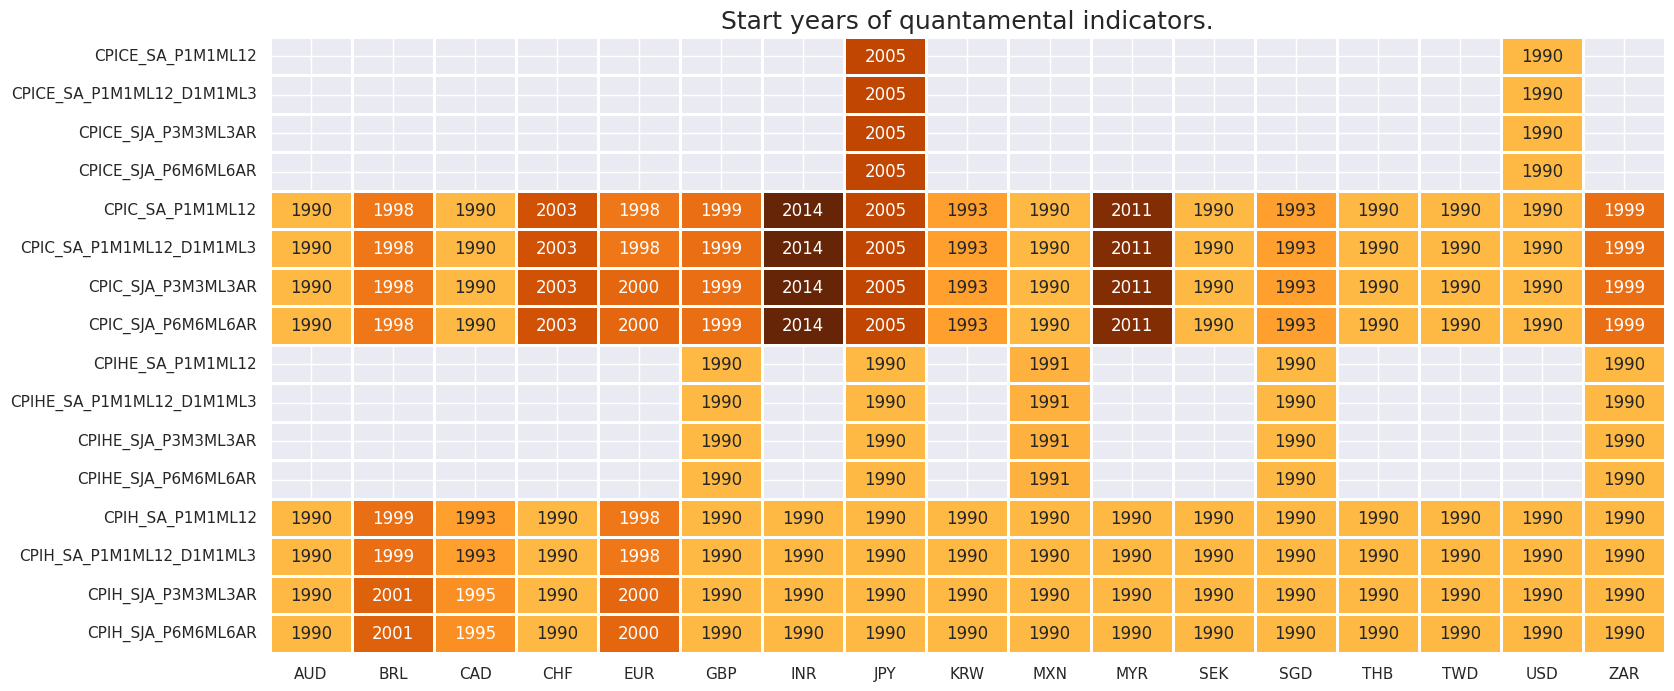

In [5]:
msm.check_availability(df, xcats = main + early, cids=cids, missing_recent=False)

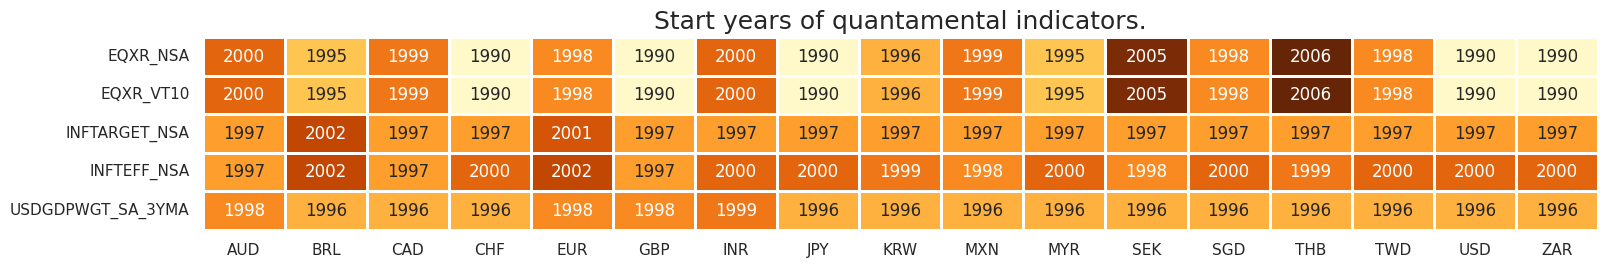

In [6]:
msm.check_availability(df, xcats = xtra + rets, cids=cids, missing_recent=False)

## Transformations and checks

### Features

#### Extended best CPI changes through hierarchical merging

In the first step, we merge the early estimation and main categories of core CPI (Consumer Price Index) and headline CPI to create a unified set of inflation categories. The early estimation indicators, where available, are given priority over the main categories starting with `CPICX_` or `CPIHX_`. This ensures that when early estimations are available, they take precedence over their respective main categories, providing a more current view of inflation trends.

In the second step, the individual core and headline CPI dictionaries are merged to create a comprehensive set of inflation categories, stored in the `dict_cpix` dictionary. This dictionary serves as the combined mapping of both core and headline CPI, allowing for easy access to the newly generated inflation categories for further processing.

In the third step, the code iterates over the dictionary of merged CPI categories `dict_cpix`, where for each new inflation category, the relevant constituent categories are merged using the `merge_categories` function from the `macrosynergy` package. This function consolidates the individual CPI components into a single unified category.

In [7]:
# Dictionary for merged core CPI and hierarchies of merged constituents
dict_cpicx = {
    "CPICX_" + chg: [cpi + chg for cpi in ["CPICE_", "CPIC_", "CPIHE_", "CPIH_"]]
    for chg in ["SA_P1M1ML12", "SJA_P6M6ML6AR", "SJA_P3M3ML3AR", "SA_P1M1ML12_D1M1ML3"]
}

# Dictionary for merged headline CPI and hierarchies of merged constituents
dict_cpihx = {
    "CPIHX_" + chg: [cpi + chg for cpi in ["CPIHE_", "CPIH_"]]
    for chg in ["SA_P1M1ML12", "SJA_P6M6ML6AR", "SJA_P3M3ML3AR", "SA_P1M1ML12_D1M1ML3"]
}

# Merge dictionary of new tickers and hierarchies of merged constituents
dict_cpix = {**dict_cpicx, **dict_cpihx}

dfa = pd.DataFrame(columns = df.columns)
for k, v in dict_cpix.items():
    dfaa = merge_categories(dfx, xcats=v, new_xcat=k)
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

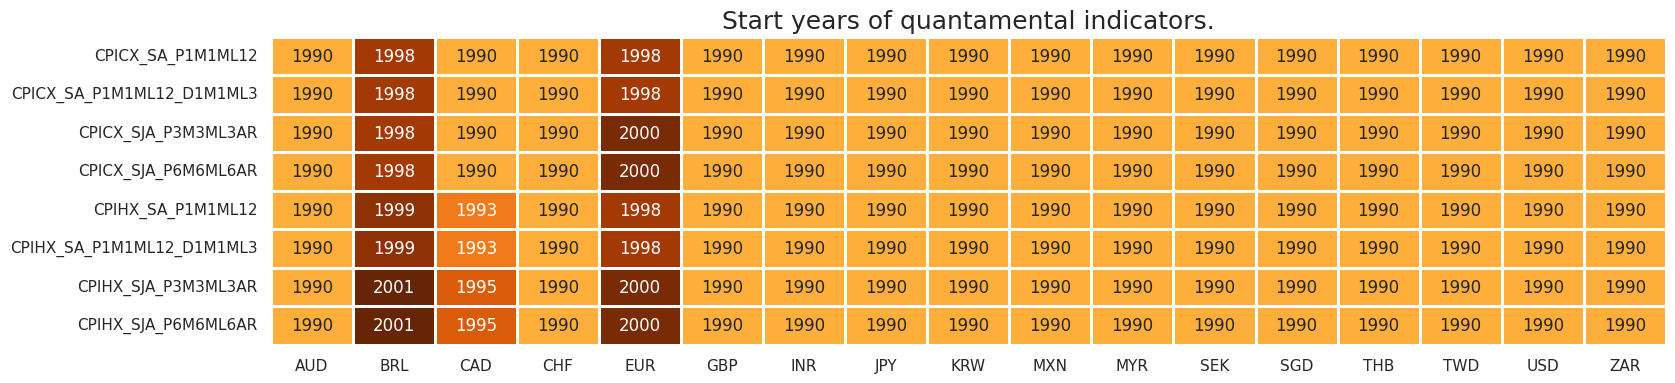

In [8]:
# Check availability of new tickers

xcatx = [k for k in dict_cpix.keys()]
msm.check_availability(dfx, xcats = xcatx, cids=cids, missing_recent=False)

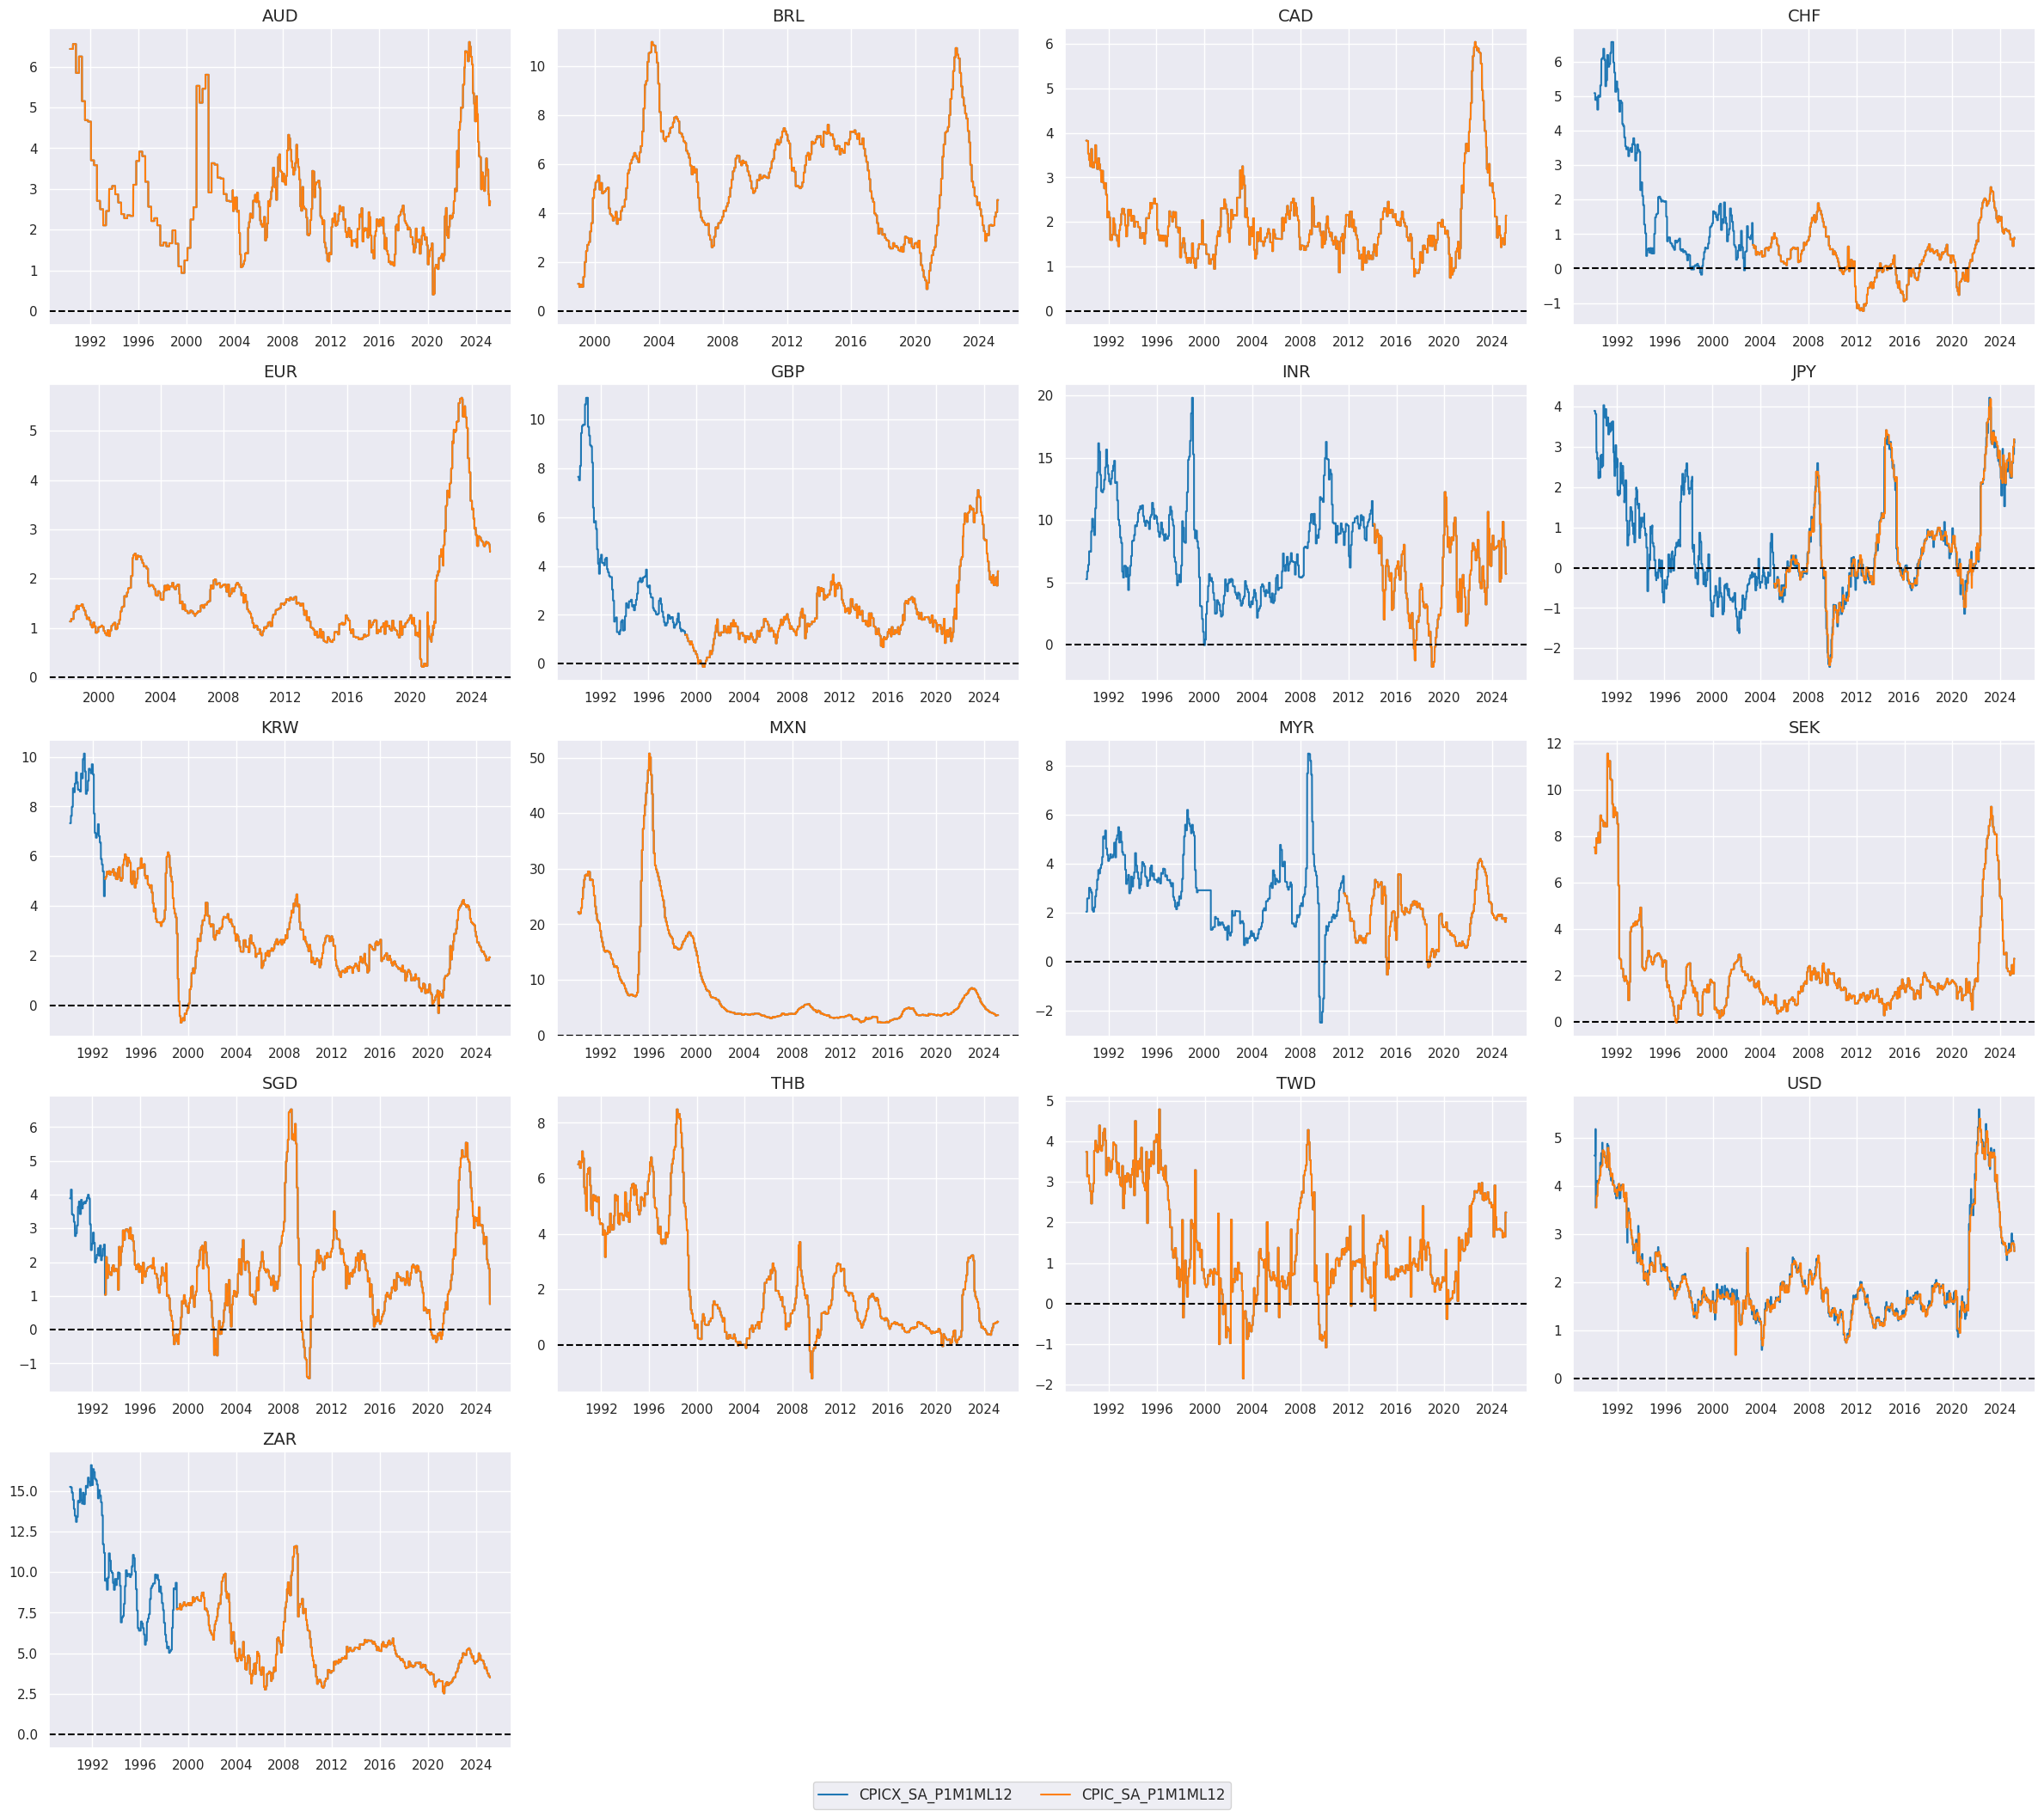

In [9]:
# Compare original and extended measures

xcatx = ["CPICX_SA_P1M1ML12", "CPIC_SA_P1M1ML12"]
cidx = cids_eq

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    cumsum=False,
    start="1990-01-01",
    same_y=False,
    all_xticks=True,
    title =None,
    title_fontsize=28,
    aspect=1.4,
    size=(8, 8),
)


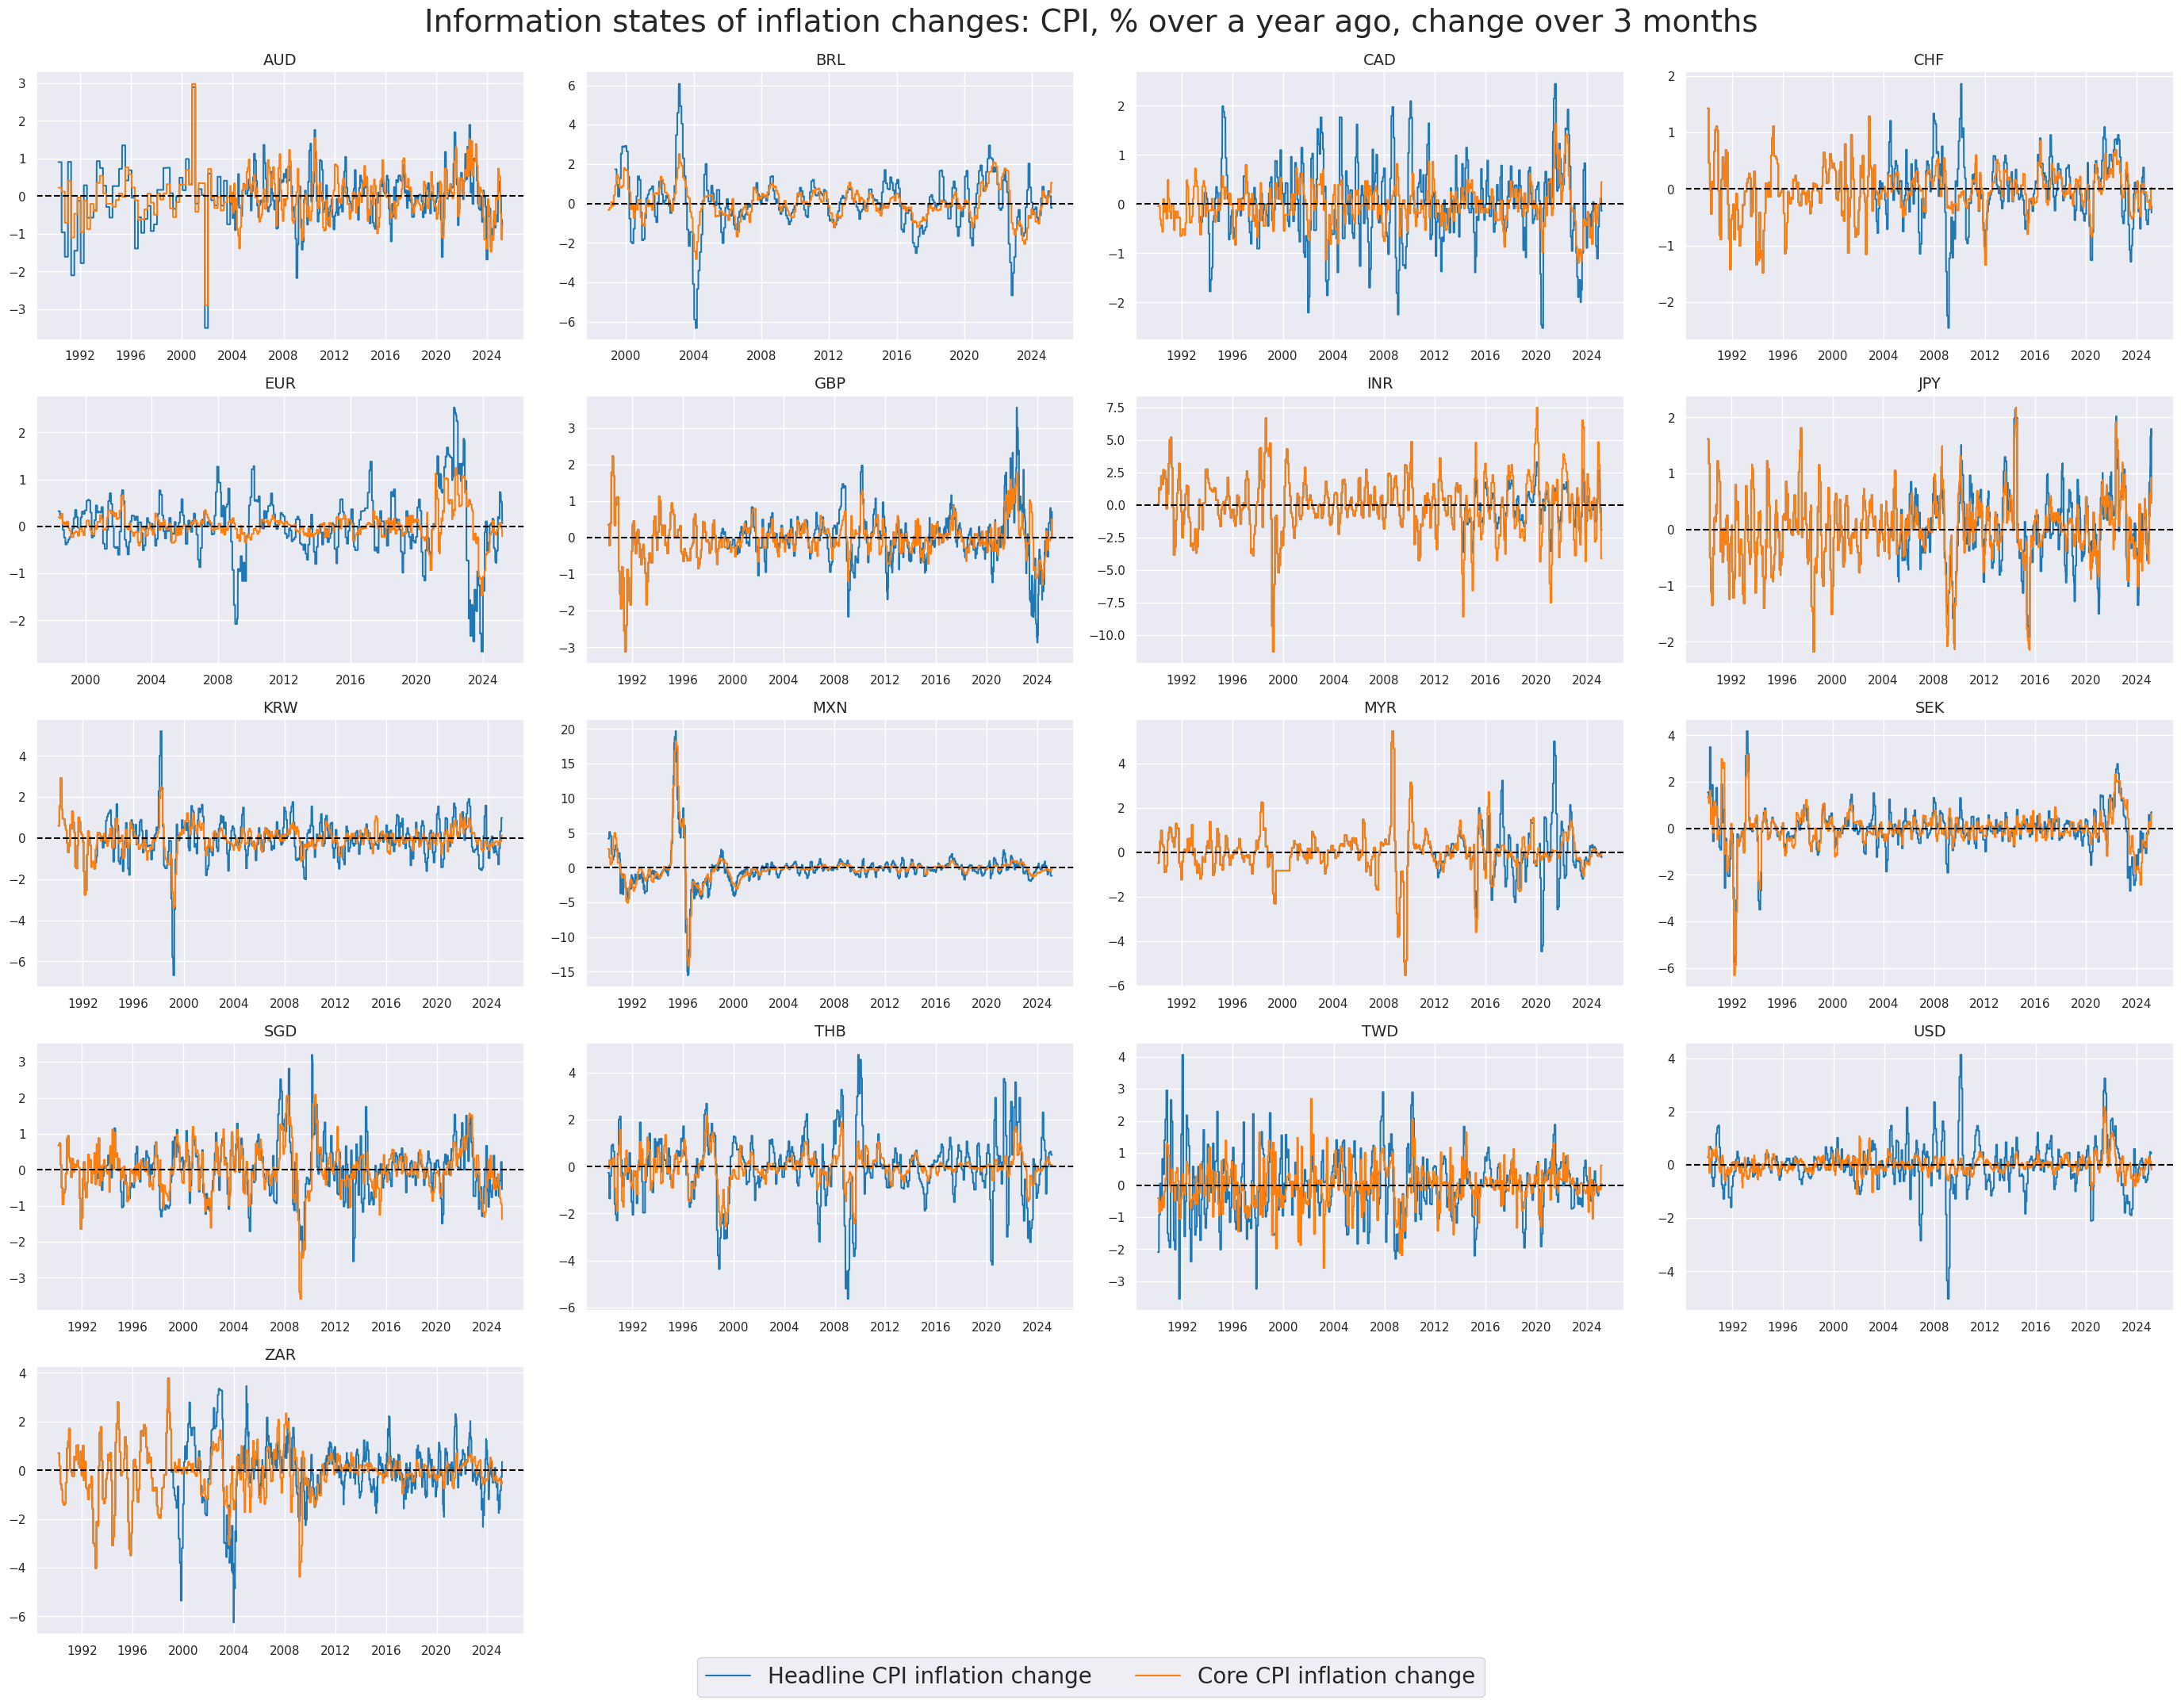

In [10]:
# Example timelines of annual inflation changes

xcatx = ["CPIHX_SA_P1M1ML12_D1M1ML3", "CPICX_SA_P1M1ML12_D1M1ML3"]
cidx = cids_eq

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    cumsum=False,
    start="1990-01-01",
    same_y=False,
    all_xticks=True,
    title ="Information states of inflation changes: CPI, % over a year ago, change over 3 months",
    title_fontsize=28,
    xcat_labels=["Headline CPI inflation change", "Core CPI inflation change"],
    legend_fontsize=20,
    size=(8, 8),
)

#### Excess inflation indicators

The estimated official target for the next calendar year, `INFTARGET_NSA`, is generally available starting from the mid to late 1990s. In the following code, we backward-fill the earliest available value for each country and category combination, extending it back to the start of 1990. This ensures that even for earlier years where data may be missing, the first available value is propagated backward to provide consistent coverage.

In [11]:
# Backward-extension of INFTARGET_NSA

# Duplicate targets
cidx = cids_eq
calcs = [f"INFTARGET_BX = INFTARGET_NSA"]
dfa = msp.panel_calculator(dfx, calcs, cids=cidx)

# Add all dates back to 1990 to the frame, filling "value " with NaN
all_dates = np.sort(dfx['real_date'].unique())
all_combinations = pd.DataFrame(
    list(itertools.product(dfa['cid'].unique(), dfa['xcat'].unique(), all_dates)),
    columns=['cid', 'xcat', 'real_date']
)
dfax = pd.merge(all_combinations, dfa, on=['cid', 'xcat', 'real_date'], how='left')

# Backfill the values with first target value
dfax = dfax.sort_values(by=['cid', 'xcat', 'real_date'])
dfax['value'] = dfax.groupby(['cid', 'xcat'])['value'].bfill()

dfx = msm.update_df(dfx, dfax)

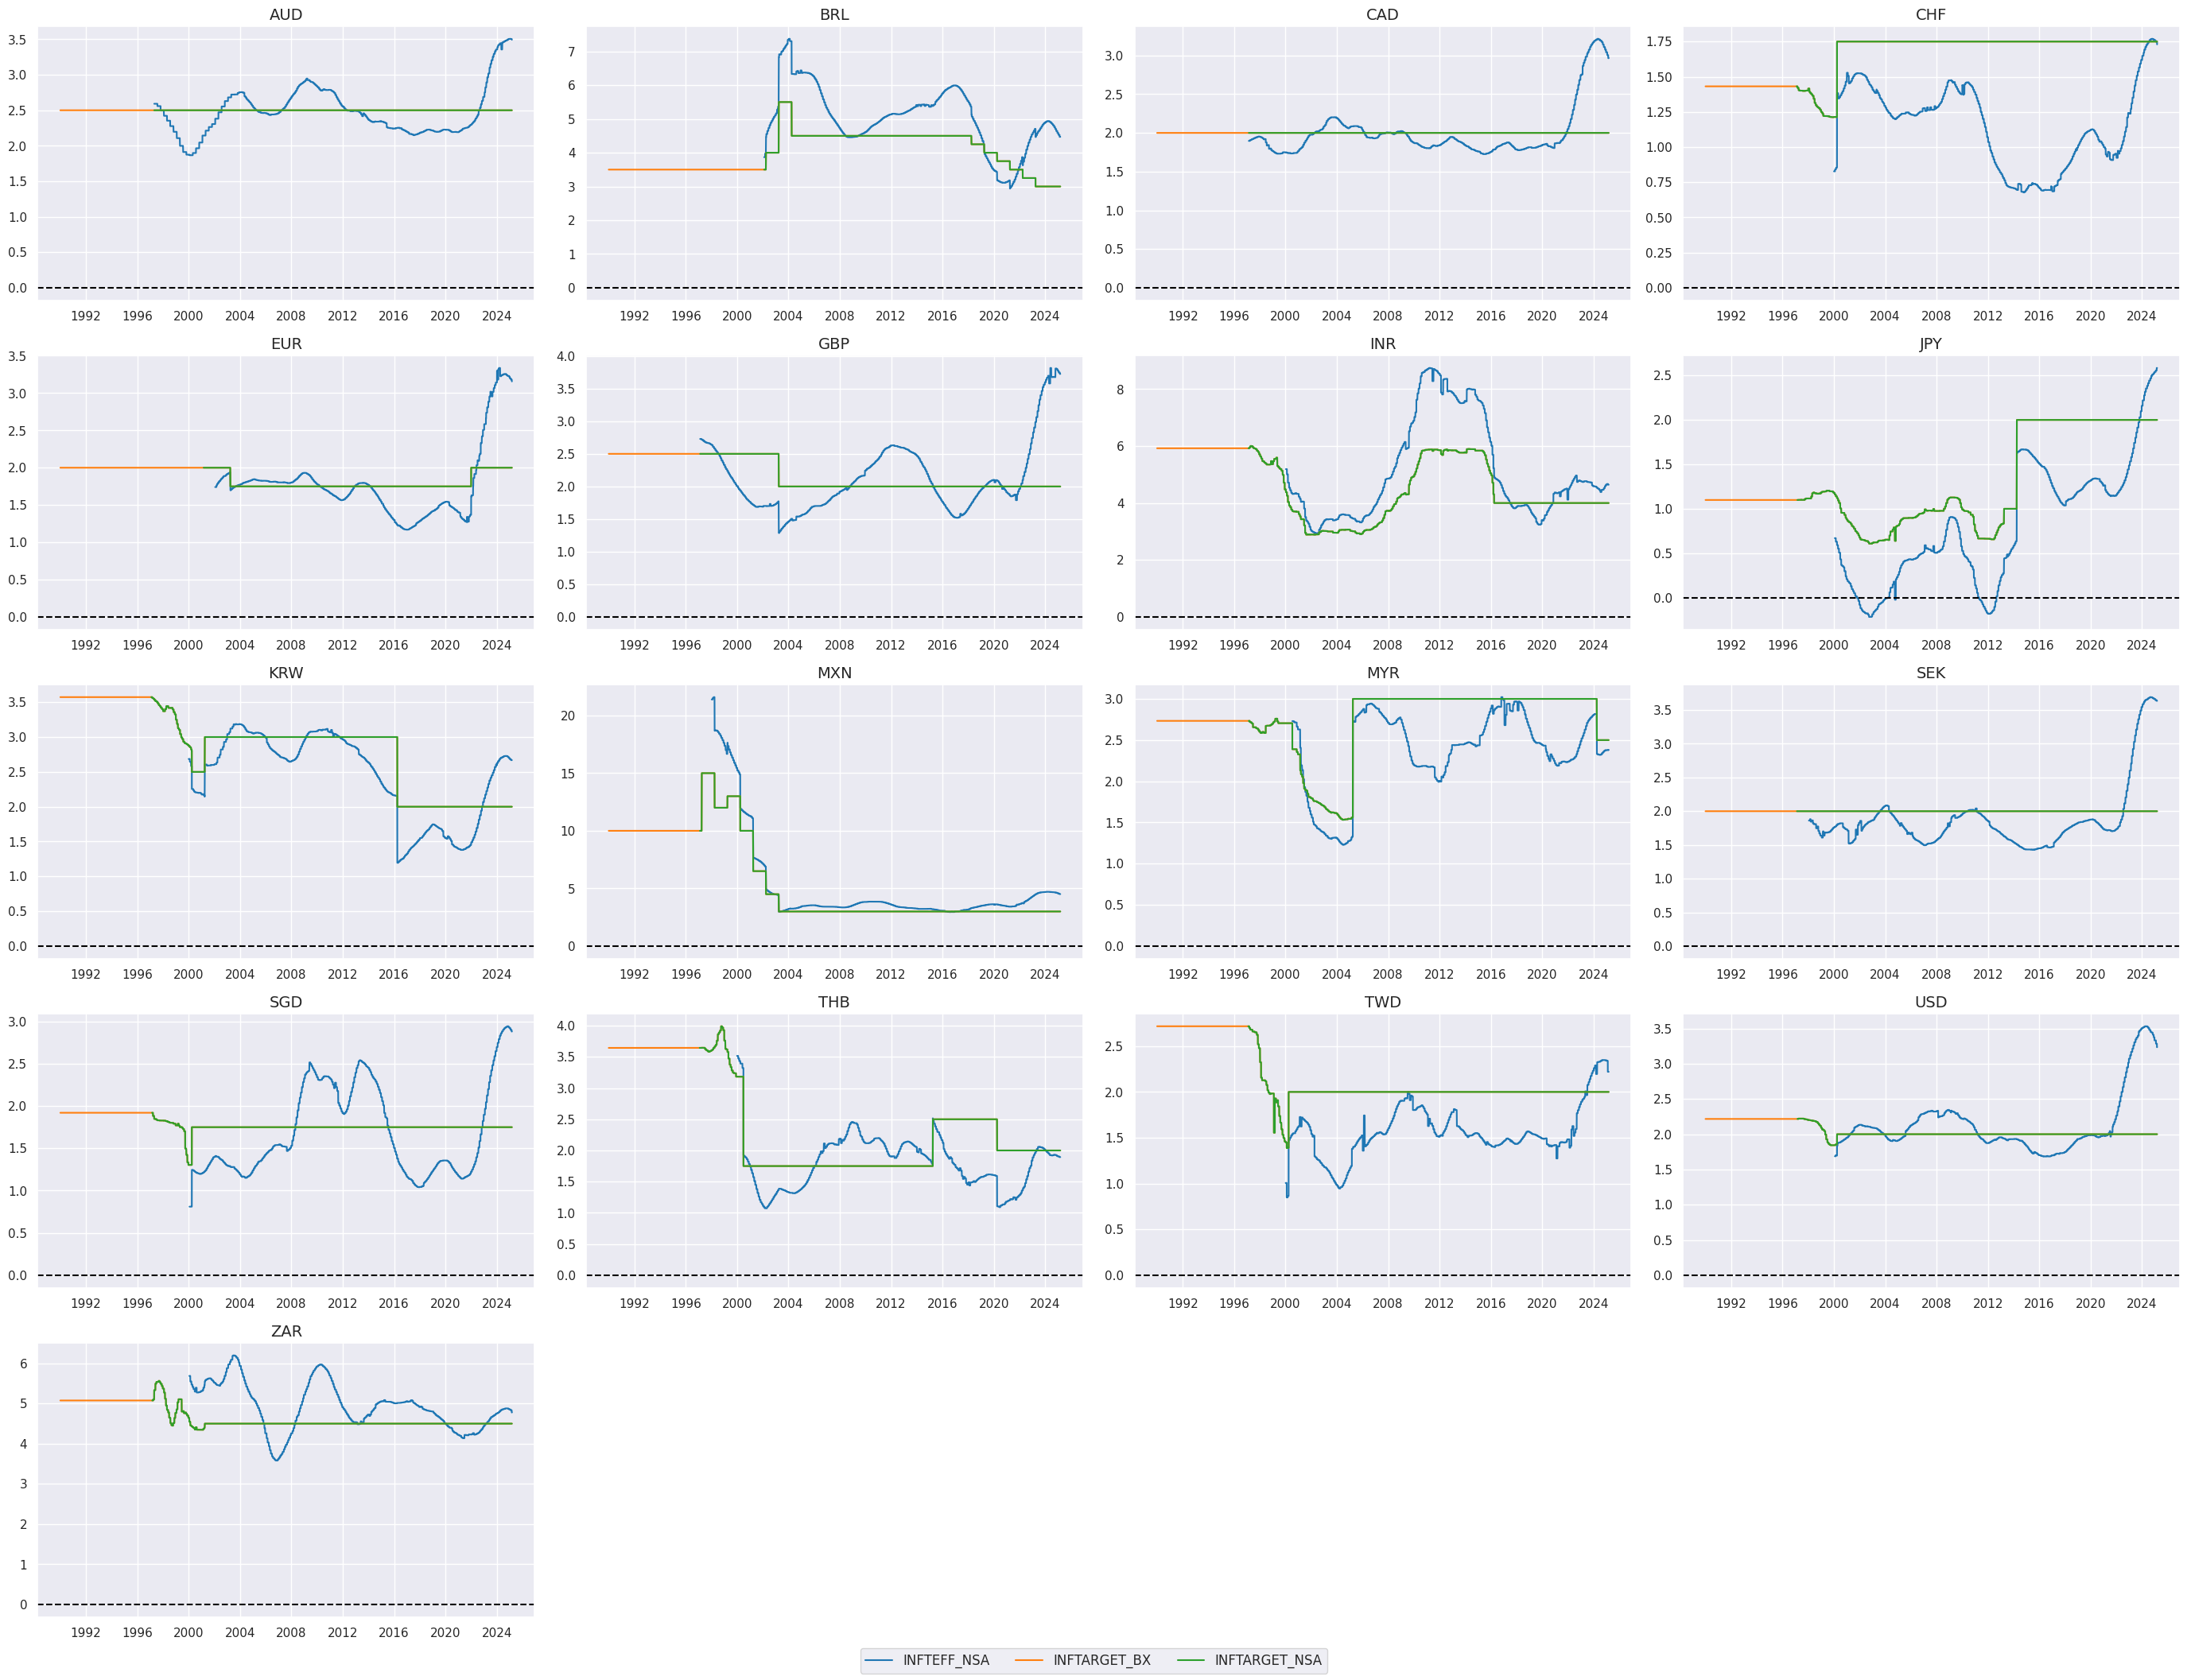

In [12]:
# Timelines of target metrics

xcatx = ["INFTEFF_NSA", "INFTARGET_BX", "INFTARGET_NSA"]
cidx = cids_eq

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    cumsum=False,
    start="1990-01-01",
    same_y=False,
    size=(12, 12),
    all_xticks=True,
    title_fontsize=20,
)

In this cell, we aim to create a unified inflation target category by merging data from two sources of inflation targets: `INFTEFF_NSA` (the effective inflation target) and `INFTARGET_BX` (the official inflation target, extended to 1990 in the cell above). The merging is performed based on a defined hierarchy, where `INFTEFF_NSA` takes priority. If data for `INFTEFF_NSA` is available, it is used in the merged category. If not, the system defaults to using the values from `INFTARGET_BX`, ensuring there are no gaps in the data. This hierarchical merging process is executed using the merge_categories function, which consolidates these two categories into a new combined category named `INFTEFF_BX`

In [13]:
# Extended effective inflation target by hierarchical merging

hierarchy = ["INFTEFF_NSA", "INFTARGET_BX"]
dfa = merge_categories(dfx, xcats=hierarchy, new_xcat="INFTEFF_BX")
dfx = msm.update_df(dfx, dfa)

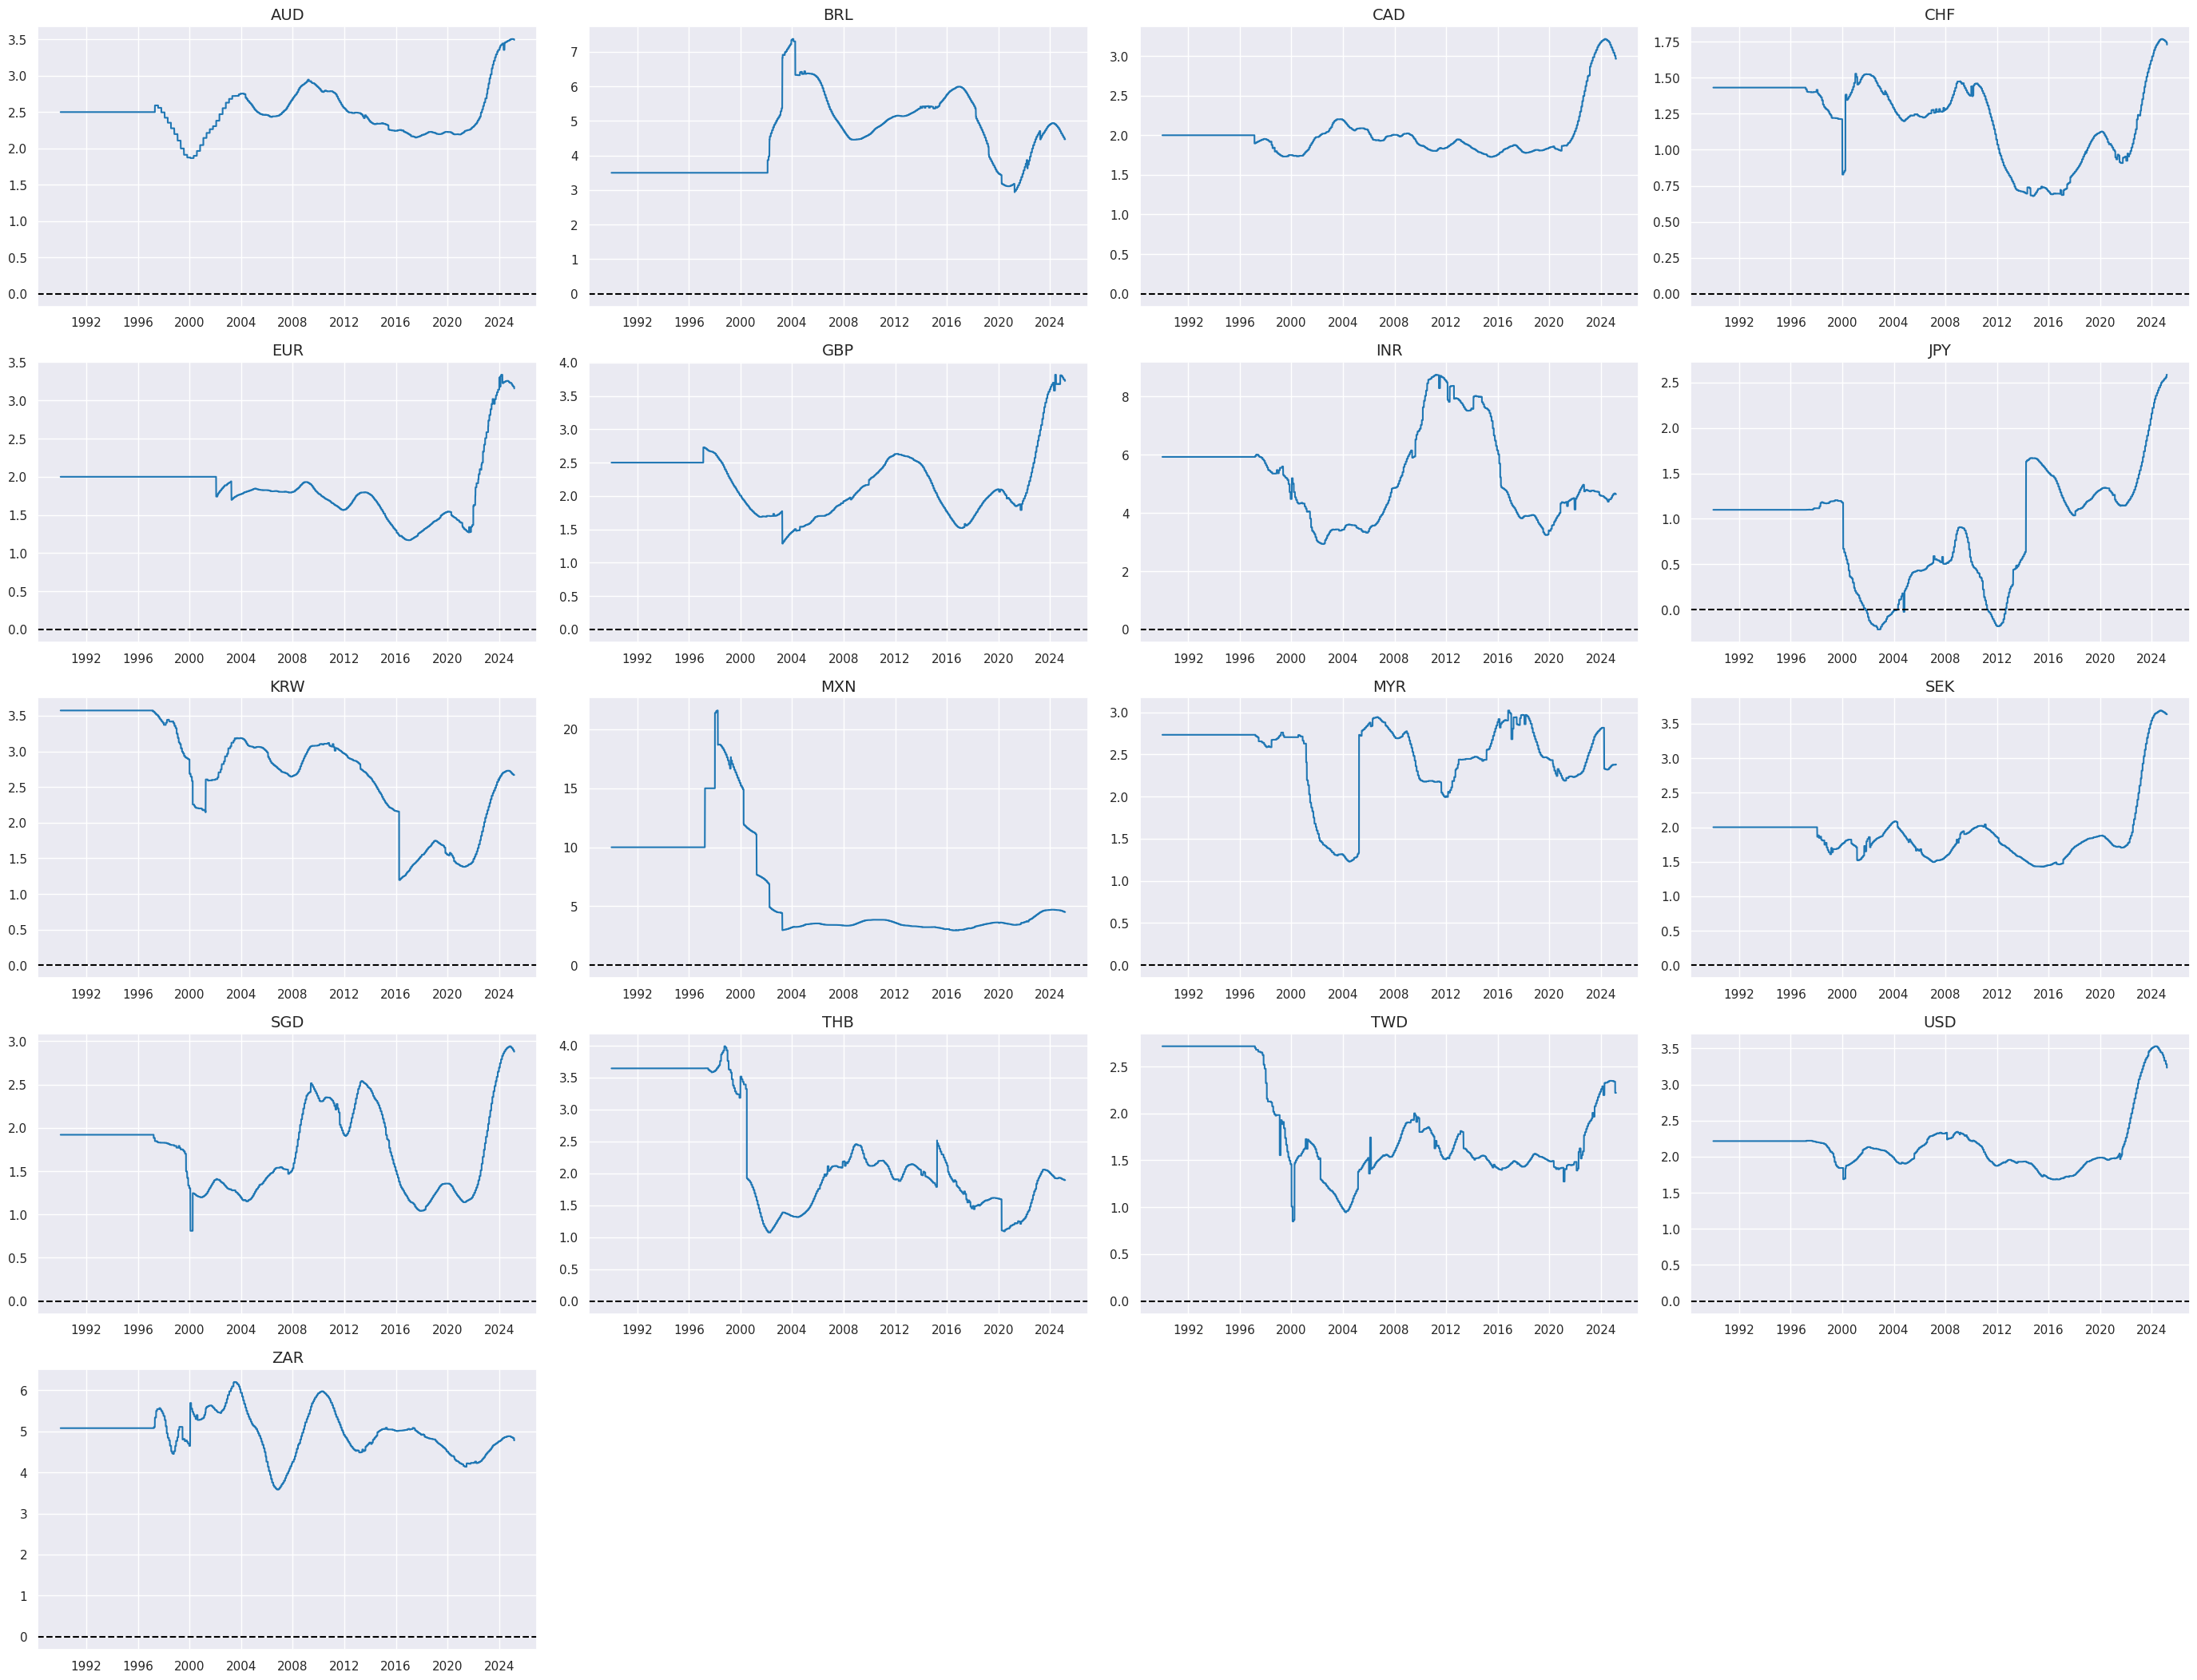

In [14]:
xcatx = ["INFTEFF_BX"]
cidx = cids_eq

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    cumsum=False,
    start="1990-01-01",
    same_y=False,
    size=(12, 12),
    all_xticks=True,
    title_fontsize=20,
)


In this step, we calculate excess inflation metrics by subtracting the effective inflation target (`INFTEFF_BX`) from both headline and core inflation metrics. These metrics are computed using extended inflation changes and targets, which have been back-populated to cover earlier periods. The new category receives suffix `vIET`

In [15]:
# Excess inflation rates versus backpropagated effective inflation target

cidx = cids_eq

infs = [k for k in dict_cpix.keys() if not k.endswith("D1M1ML3")]
calcs = [f"{inf}vIET = {inf} - INFTEFF_BX" for inf in infs]

dfa = msp.panel_calculator(dfx, calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

xinfs = list(dfa["xcat"].unique())

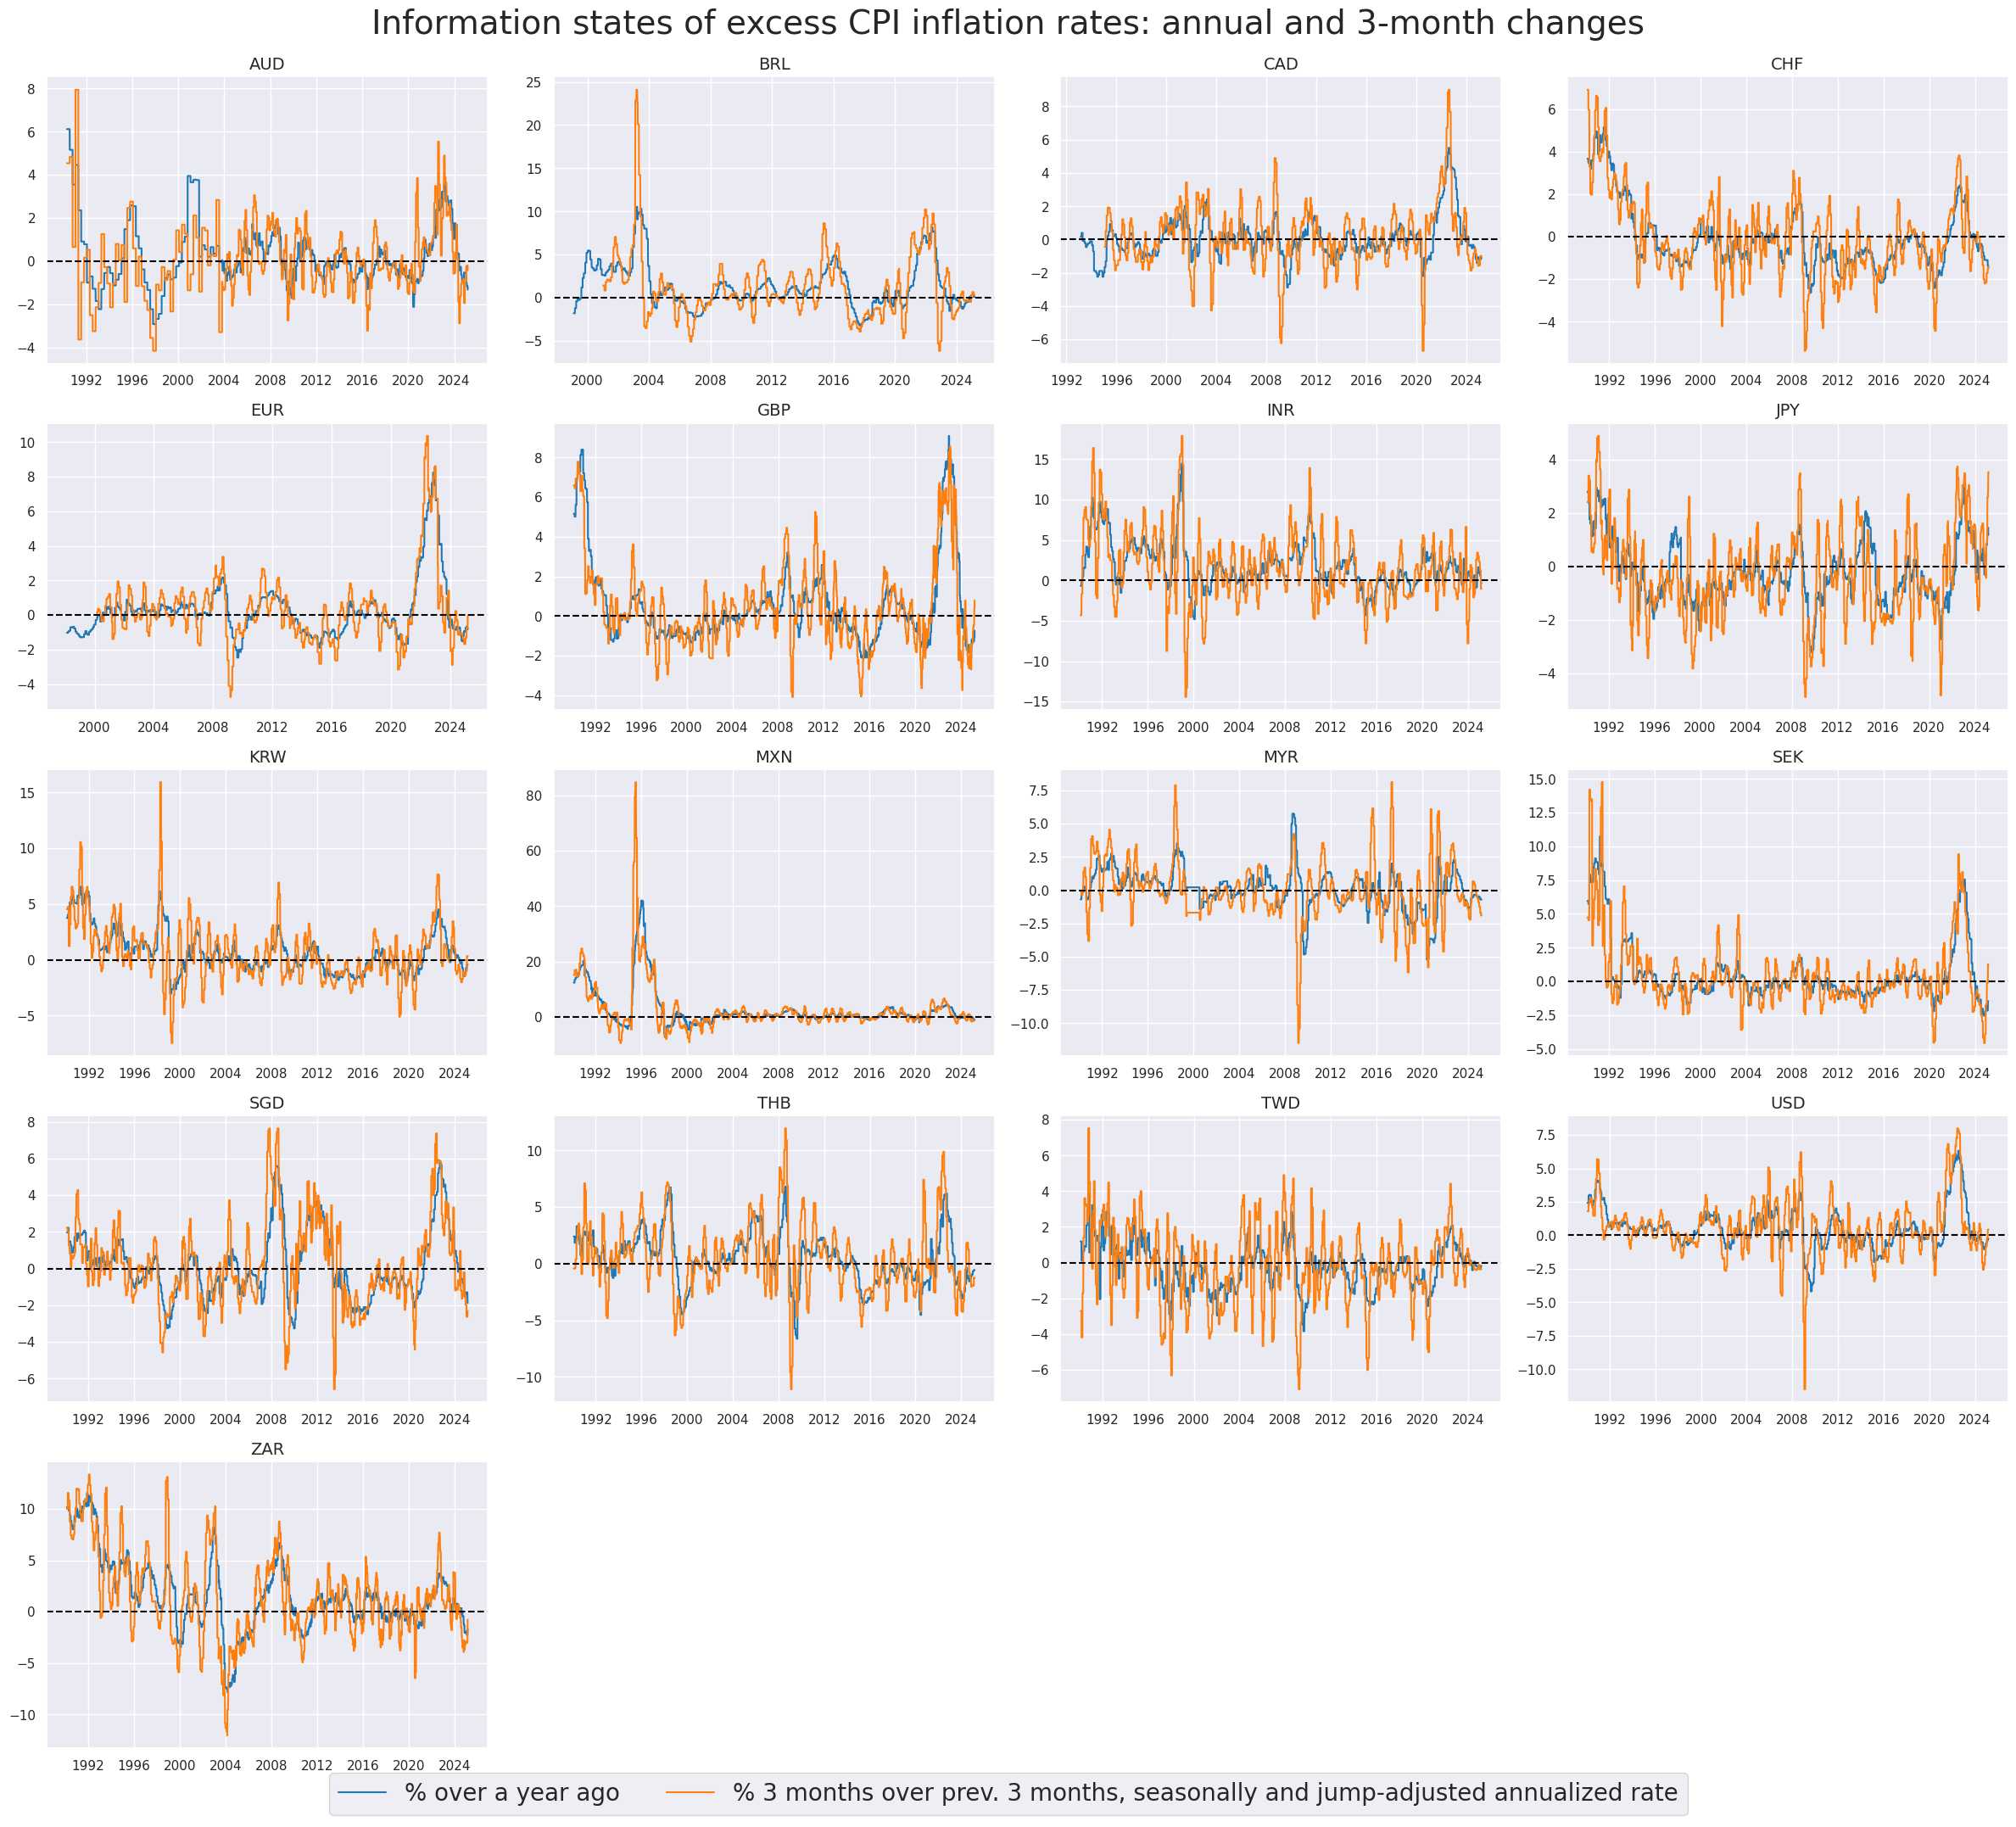

In [16]:
# Example timelines of excess inflation

xcatx = ["CPIHX_SA_P1M1ML12vIET", "CPIHX_SJA_P3M3ML3ARvIET"]
cidx = cids_eq

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    cumsum=False,
    start="1990-01-01",
    same_y=False,
    all_xticks=True,
    title ="Information states of excess CPI inflation rates: annual and 3-month changes",
    title_fontsize=28,
    xcat_labels=["% over a year ago", "% 3 months over prev. 3 months, seasonally and jump-adjusted annualized rate"],
    legend_fontsize=20,
    aspect=1.4,
    size=(8, 8),
)

This cell aggregates inflation metrics into one list `infs` for further analysis, combining categories that include both the difference between inflation and its target (`xinfs`) and inflation change metrics (`inf_chgs`).

In [17]:
inf_chgs = [k for k in dict_cpix.keys() if k.endswith("D1M1ML3")]  # inflation changes
infs = xinfs + inf_chgs
display(infs)

['CPICX_SA_P1M1ML12vIET',
 'CPICX_SJA_P6M6ML6ARvIET',
 'CPICX_SJA_P3M3ML3ARvIET',
 'CPIHX_SA_P1M1ML12vIET',
 'CPIHX_SJA_P6M6ML6ARvIET',
 'CPIHX_SJA_P3M3ML3ARvIET',
 'CPICX_SA_P1M1ML12_D1M1ML3',
 'CPIHX_SA_P1M1ML12_D1M1ML3']

#### Global aggregates of inflation information

Similarly to how we handle excess inflation rates, we backpropagate GDP weights to 1990 by filling in earlier missing values using the earliest available data for each country and category combination.

In [18]:
# Backprogation of GDP weights

# Duplicate weights
cidx = cids_eq
calcs = [f"USDGDPWGT_BX = USDGDPWGT_SA_3YMA"]
dfa = msp.panel_calculator(dfx, calcs, cids=cidx)

# Add all dates back to 1990 to the frame, filling "value " with NaN
all_dates = np.sort(dfx['real_date'].unique())
all_combinations = pd.DataFrame(
    list(itertools.product(dfa['cid'].unique(), dfa['xcat'].unique(), all_dates)),
    columns=['cid', 'xcat', 'real_date']
)
dfax = pd.merge(all_combinations, dfa, on=['cid', 'xcat', 'real_date'], how='left')

# Backfill the values with first traget value
dfax = dfax.sort_values(by=['cid', 'xcat', 'real_date'])
dfax['value'] = dfax.groupby(['cid', 'xcat'])['value'].bfill()

dfx = msm.update_df(dfx, dfax)

The code computes GDP-weighted linear composites for various inflation-related categories across two global groupings: one including all countries (`GLB`) and another excluding the U.S. (`GLX`). It uses `USDGDPWGT_BX` as the weighting factor to ensure that each country's economic size is reflected in the composite calculations. 

In [19]:
# Weighted global averages

xcatx = infs
dict_globals = {
    "GLB": cids_eq,
    "GLX": list(set(cids_eq) - set(["USD"])),
}

dfa = pd.DataFrame(columns = df.columns)

for k, v in dict_globals.items():
    for xc in xcatx:
        dfaa = msp.linear_composite(
            df=dfx,
            xcats=xc,
            cids=v,
            weights="USDGDPWGT_BX",
            new_cid=k,
        )
        dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

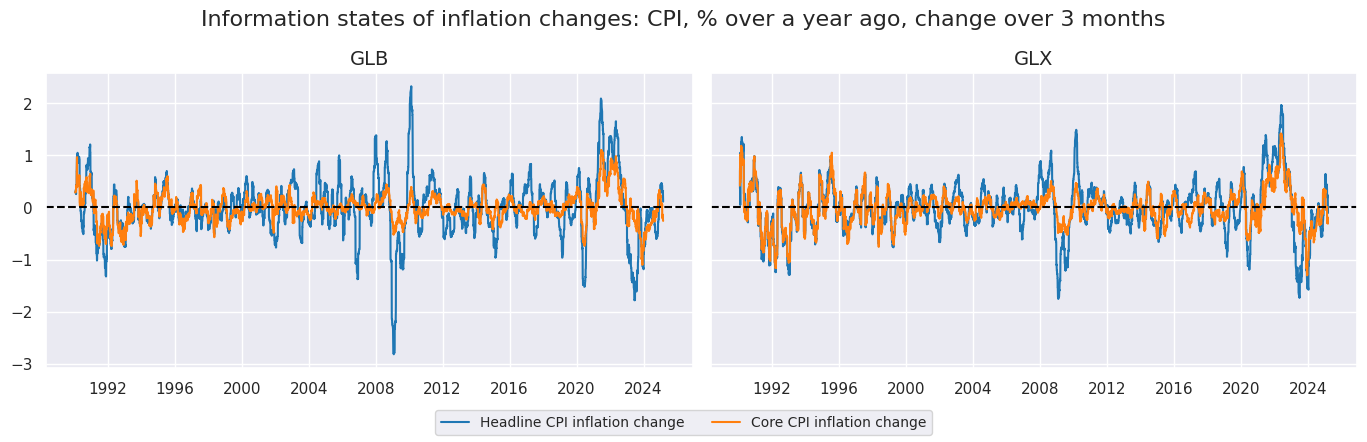

In [20]:
xcatx = ["CPIHX_SA_P1M1ML12_D1M1ML3", "CPICX_SA_P1M1ML12_D1M1ML3"]
cidx = ["GLB", "GLX"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=2,
    cumsum=False,
    start="1990-01-01",
    same_y=True,
    all_xticks=True,
    title ="Information states of inflation changes: CPI, % over a year ago, change over 3 months",
    title_fontsize=16,
    xcat_labels=["Headline CPI inflation change", "Core CPI inflation change"],
    legend_fontsize=10,
    size=(18, 18),
)

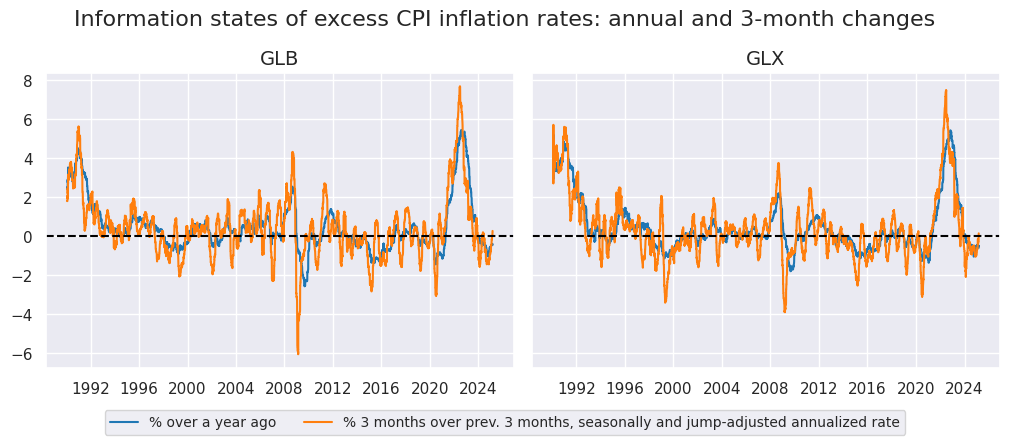

In [21]:
xcatx = ["CPIHX_SA_P1M1ML12vIET", "CPIHX_SJA_P3M3ML3ARvIET"]
cidx = ["GLB", "GLX"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=2,
    cumsum=False,
    start="1990-01-01",
    same_y=True,
    all_xticks=True,
    title ="Information states of excess CPI inflation rates: annual and 3-month changes",
    title_fontsize=16,
    xcat_labels=["% over a year ago", "% 3 months over prev. 3 months, seasonally and jump-adjusted annualized rate"],
    legend_fontsize=10,
    aspect=1.2,
    size=(18, 18),
)

### Targets

#### Groupwise equity index returns

The code calculates linear composites for two equity-related categories, `EQXR_NSA` and `EQXR_VT10`, across two global groupings: one including all countries (`GLB`) and another excluding the U.S. (`GLX`). 

In [22]:
# Global averages

xcatx = ["EQXR_NSA", "EQXR_VT10"]
dict_globals = {
    "GLB": cids_eq,
    "GLX": list(set(cids_eq) - set(["USD"])),
}

dfa = pd.DataFrame(columns = df.columns)

for k, v in dict_globals.items():
    for xc in xcatx:
        dfaa = msp.linear_composite(
            df=dfx,
            xcats=xc,
            cids=v,
            new_cid=k,
        )
        dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

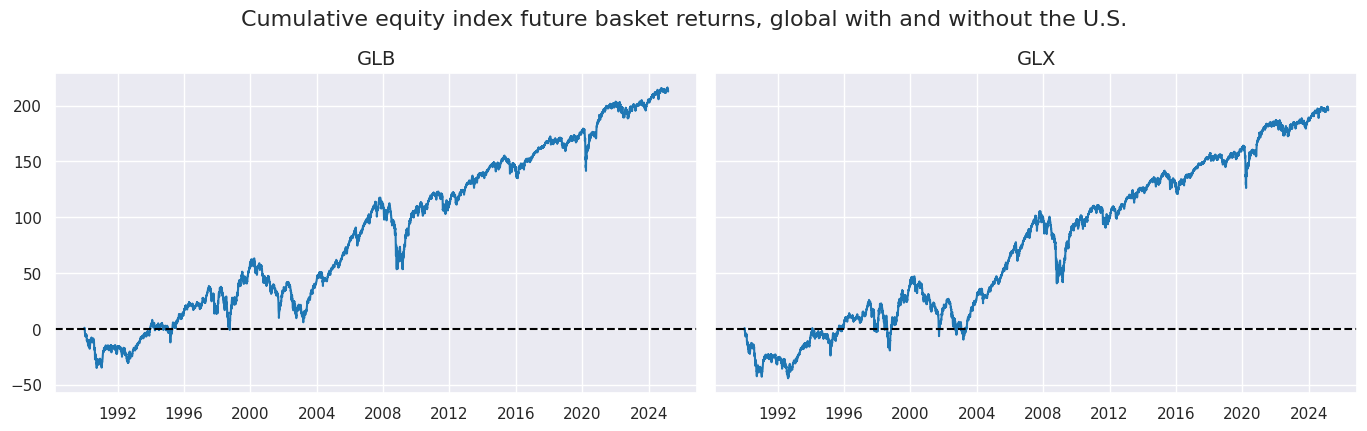

In [23]:
xcatx = ["EQXR_NSA"]
cidx = ["GLB", "GLX"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=2,
    cumsum=True,
    start="1990-01-01",
    same_y=True,
    all_xticks=True,
    title ="Cumulative equity index future basket returns, global with and without the U.S.",
    title_fontsize=16,
    size=(18, 18),
)

## Value checks

### Inflation changes

#### Specs and correlation

In [24]:
labels = {
    "CPIHX_SA_P1M1ML12_D1M1ML3": "Headline CPI inflation, %oya, diff over 3m",
    "CPICX_SA_P1M1ML12_D1M1ML3": "Core CPI inflation, %oya, diff over 3m",
}

dict_ic = {
    "sigs": [key for key in labels.keys()],
    "targs": ["EQXR_NSA", "EQXR_VT10"],
    "cids": ["GLB", "GLX"],
    "start": "1990-01-01",
    "labels": labels,
    "cr": None,
    "srr": None,
    "pnls": None
}

In [25]:
dix = dict_ic
sigx = dix["sigs"]
cidx = dix["cids"]
targ = dix["targs"][0] 
start = dix["start"] 


crx = {}

# create category relation objects for each signal and frequency:

for sig in sigx:
    for cid in cidx: 
        crx[f"cr_{cid}_{sig}"] = msp.CategoryRelations(
            dfx,
            xcats=[sig, targ],
            cids=[cid],
            lag=1,
            xcat_aggs=["last", "sum"],
            start=start,
            xcat_trims=[None, None]
        )

dix["cr"] = crx


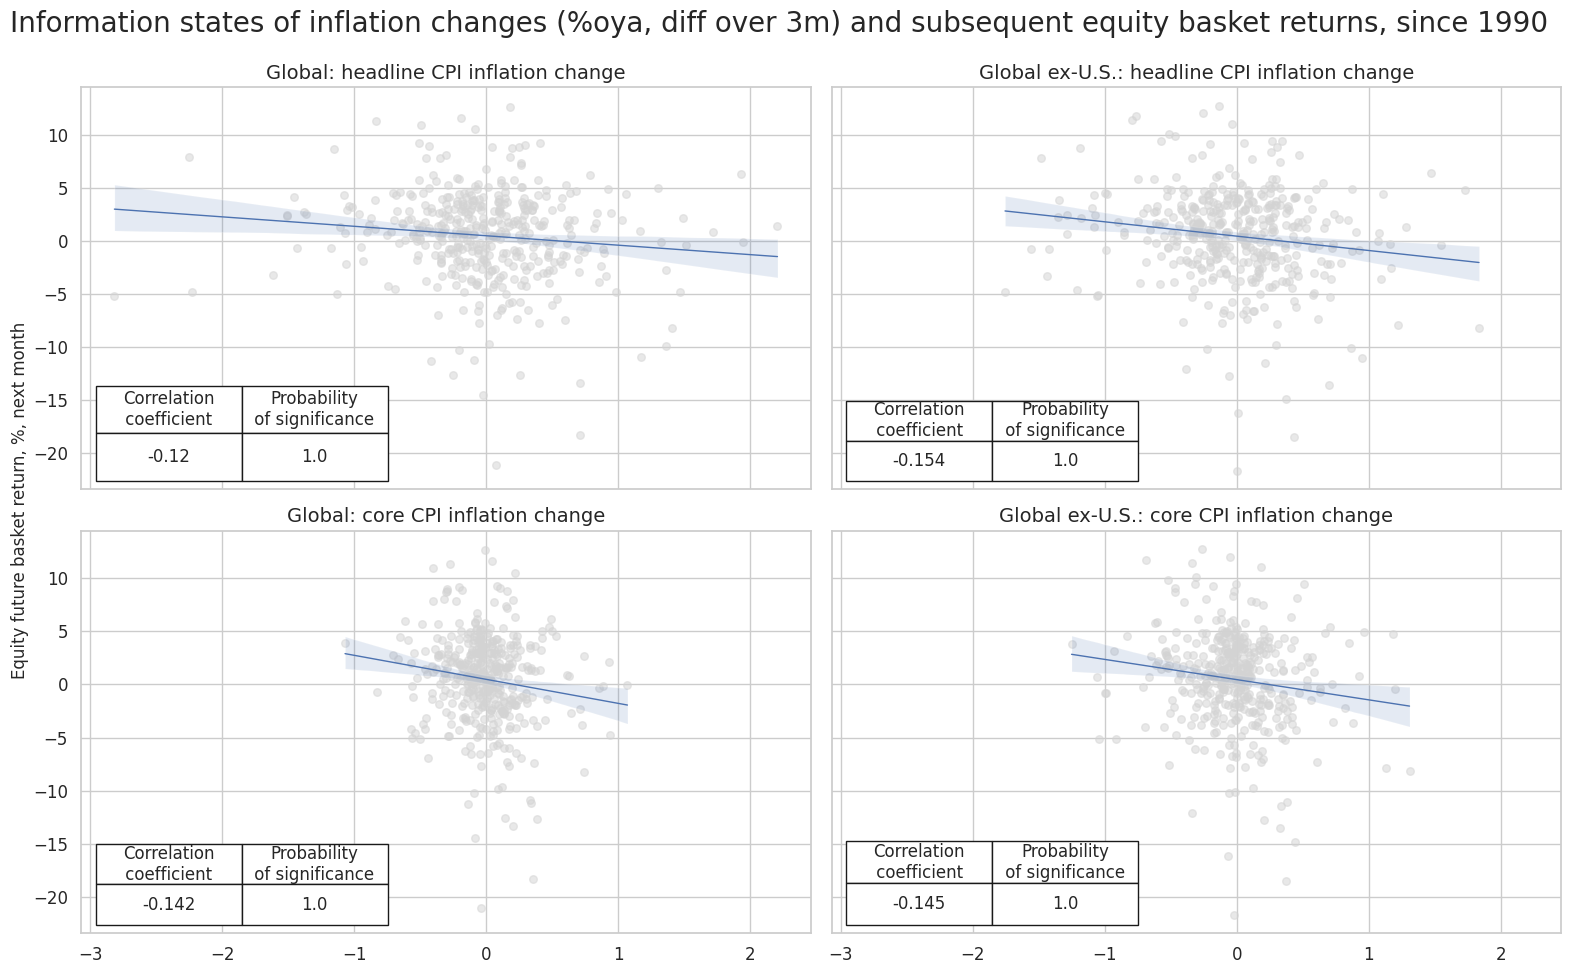

In [26]:
dix = dict_ic
crx = dix["cr"]
sigx = dix["sigs"]
cidx = dix["cids"]

rels = [f"cr_{cid}_{sig}" for sig in sigx for cid in cidx]
dict_rels = {
    'cr_GLB_CPICX_SA_P1M1ML12_D1M1ML3': "Global: core CPI inflation change",
    'cr_GLB_CPIHX_SA_P1M1ML12_D1M1ML3': "Global: headline CPI inflation change",
    'cr_GLX_CPICX_SA_P1M1ML12_D1M1ML3': "Global ex-U.S.: core CPI inflation change",
    'cr_GLX_CPIHX_SA_P1M1ML12_D1M1ML3': "Global ex-U.S.: headline CPI inflation change",
}
rel_labels = [dict_rels[rel] for rel in rels]


msv.multiple_reg_scatter(
    cat_rels=[crx[rel] for rel in rels],
    title="Information states of inflation changes (%oya, diff over 3m) and subsequent equity basket returns, since 1990",
    ylab="Equity future basket return, %, next month",
    ncol=2,
    nrow=len(rels) // 2,
    figsize=(16, 10),
    prob_est="map",
    coef_box="lower left",
    subplot_titles=rel_labels
)

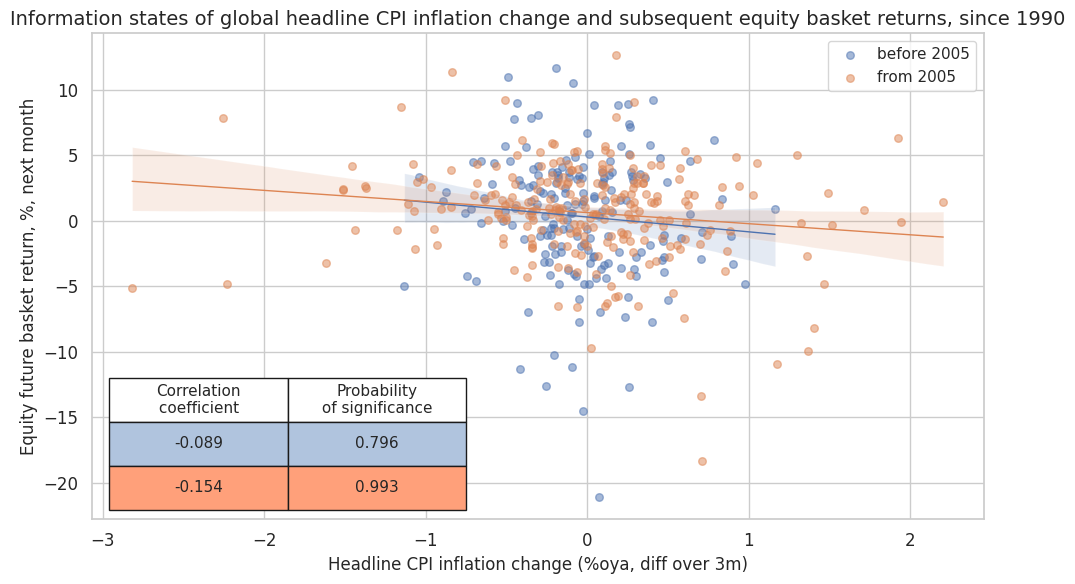

In [27]:
dix = dict_ic
crx = dix["cr"] 

rel = "cr_GLB_CPIHX_SA_P1M1ML12_D1M1ML3"

crx[rel].reg_scatter( 
    labels=False,
    coef_box="lower left",
    title="Information states of global headline CPI inflation change and subsequent equity basket returns, since 1990",
    xlab="Headline CPI inflation change (%oya, diff over 3m)",
    ylab="Equity future basket return, %, next month",
    separator=2005,
    prob_est="map",
    size=(10, 6),
)

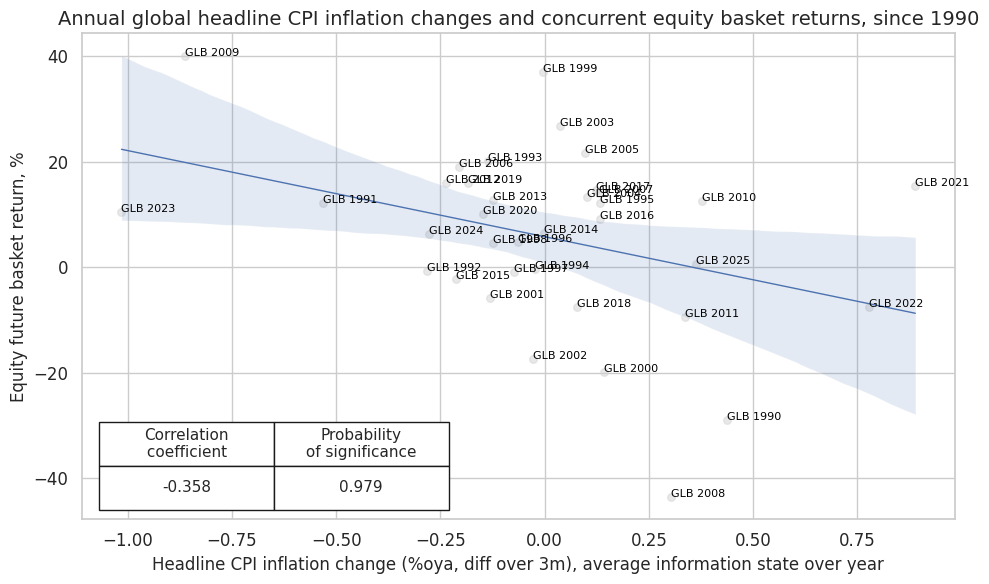

In [28]:
# Concurrent relations

dix = dict_ic
cidx = dix["cids"]
targ = dix["targs"][0] 
start = dix["start"] 

sig = "CPIHX_SA_P1M1ML12_D1M1ML3"


cr = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=["GLB"],
    lag=0,
    xcat_aggs=["mean", "sum"],
    freq="A",
    start=start,
    xcat_trims=[None, None],
)

cr.reg_scatter( 
    labels=True,
    coef_box="lower left",
    title="Annual global headline CPI inflation changes and concurrent equity basket returns, since 1990",
    xlab="Headline CPI inflation change (%oya, diff over 3m), average information state over year",
    ylab="Equity future basket return, %",
    prob_est="map",
    size=(10, 6),
)

#### Accuracy and correlation check

In [29]:
dix = dict_ic

sigx = dix["sigs"]
targ = dix["targs"][0]
cidx = dix["cids"]
start = dix["start"] 

srrs ={}

for cid in cidx:
    srrs[f"srr_{cid}"] = mss.SignalReturnRelations(
        dfx,
        cids=[cid],
        sigs=sigx,
        sig_neg=[True] * len(sigx),
        rets=targ,
        freqs="M",
        start=start,
    )

dix["srr"] = srrs

In [30]:
dix = dict_ic
srrs = dix["srr"]
labels = dix["labels"]

sig_labels = dict(
    zip(
        [key + "_NEG" for key in labels.keys()],
        [val + " (neg)" for val in labels.values()],
    )
)


# for column modifications
dict_cols = {
    "Signal" : "Signal",
    "accuracy": "Accuracy",
    "bal_accuracy": "Balanced accuracy",
    "pos_sigr": "Share of positive signals",
    "pos_retr": "Share of positive returns",
    "pearson": "Pearson coefficient",
    "kendall": "Kendall coefficient",
}



dict_cids={
    "GLB": "Global",
    "GLX": "Global ex-U.S.",
}



for cid in cidx:
    srr = srrs[f"srr_{cid}"]
    tbl = srr.multiple_relations_table(signal_name_dict=sig_labels)
    tbl = tbl.reset_index()
    tbl.rename(columns=dict_cols, inplace=True)
    tblx = tbl.set_index('Signal').drop(columns=['Return', 'Frequency', 'Aggregation', 'auc', 'pos_prec', 'neg_prec', 'pearson_pval', 'kendall_pval'])
  #  print(cid)
    

    tblx = tblx.style.format("{:.2f}").set_caption(
     f"Predictive accuracy and correlation with respect to {dict_cids.get(cid, cid)} returns").set_table_styles(
    [{"selector": "caption", "props": [("text-align", "center"), ("font-weight", "bold"), ("font-size", "17px")]}])
    display(tblx)

#### Naive PnLs

In [31]:
dix = dict_ic

sigx = dix["sigs"]
targ = dix["targs"][0]
cidx = dix["cids"]
start = dix["start"]

pnls = {}

for cid in cidx:
    pnl = msn.NaivePnL(
        dfx,
        ret=targ,
        sigs=sigx,
        cids=[cid],
        start=start,
        bms=["USD_EQXR_NSA"],
    )

    for sig in sigx:
        pnl.make_pnl(
            sig,
            sig_neg=True,
            sig_op="zn_score_pan",
            sig_add = 0.5,
            rebal_freq="weekly",
            vol_scale=10,
            rebal_slip=1,
            thresh=4,
            pnl_name=sig + "_NEGPZN",
        )

    pnl.make_long_pnl(vol_scale=10, label="Long only")
    pnls[f"pnls_{cid}"] = pnl

dix["pnls"] = pnls

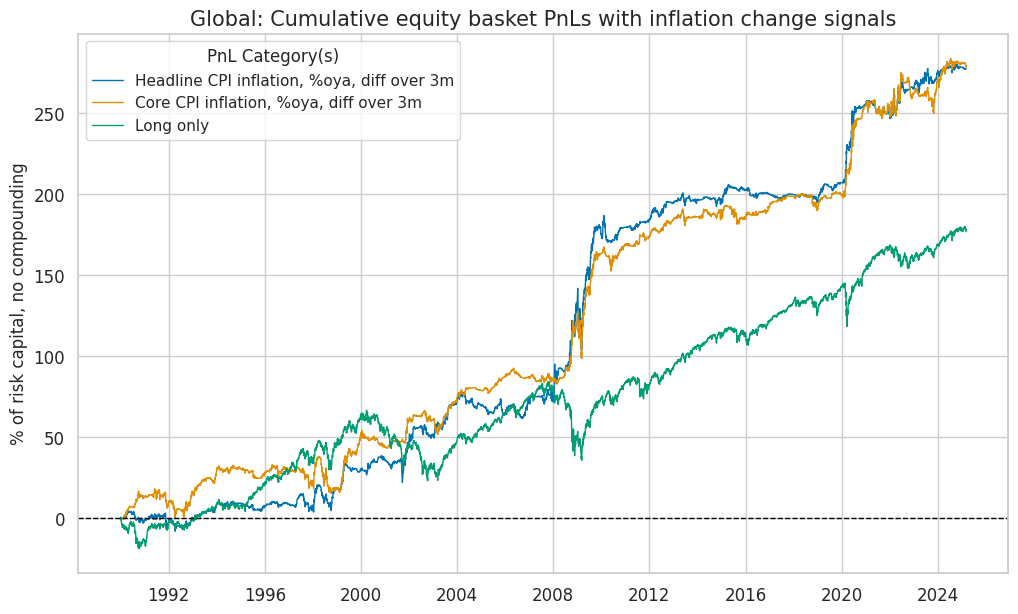

xcat                      Headline CPI inflation, %oya, diff over 3m  \
Return %                                                        7.90   
St. Dev. %                                                     10.00   
Sharpe Ratio                                                    0.79   
Sortino Ratio                                                   1.22   
Max 21-Day Draw %                                             -25.05   
Max 6-Month Draw %                                            -15.56   
Peak to Trough Draw %                                         -37.77   
Top 5% Monthly PnL Share                                        0.77   
USD_EQXR_NSA correl                                             0.13   
Traded Months                                                 423.00   

xcat                      Core CPI inflation, %oya, diff over 3m  Long only  
Return %                                                    7.92       5.03  
St. Dev. %                                                 10.00      10.00  
Sharpe Ratio                                                0.79       0.50  
Sortino Ratio                                               1.19       0.70  
Max 21-Day Draw %                                         -23.33     -25.76  
Max 6-Month Draw %                                        -22.48     -38.71  
Peak to Trough Draw %                                     -29.13     -48.48  
Top 5% Monthly PnL Share                                    0.74       0.71  
USD_EQXR_NSA correl                                         0.13       0.92  
Traded Months                                             423.00     423.00

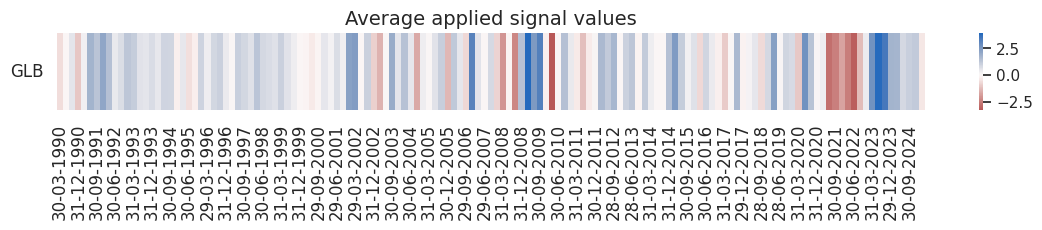

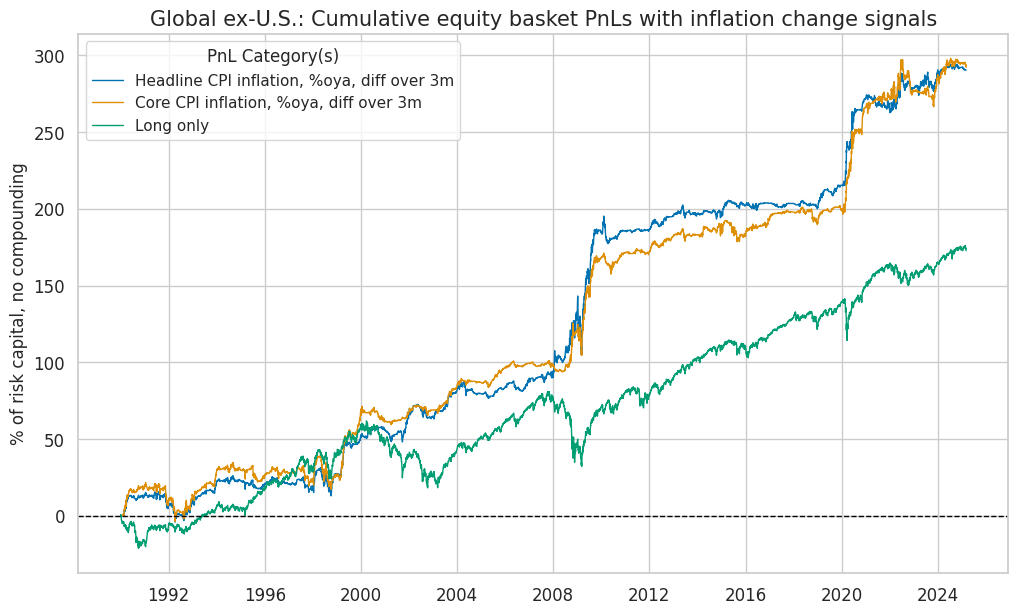

xcat                      Headline CPI inflation, %oya, diff over 3m  \
Return %                                                        8.28   
St. Dev. %                                                     10.00   
Sharpe Ratio                                                    0.83   
Sortino Ratio                                                   1.28   
Max 21-Day Draw %                                             -25.04   
Max 6-Month Draw %                                            -17.14   
Peak to Trough Draw %                                         -38.50   
Top 5% Monthly PnL Share                                        0.75   
USD_EQXR_NSA correl                                             0.14   
Traded Months                                                 423.00   

xcat                      Core CPI inflation, %oya, diff over 3m  Long only  
Return %                                                    8.33       4.91  
St. Dev. %                                                 10.00      10.00  
Sharpe Ratio                                                0.83       0.49  
Sortino Ratio                                               1.26       0.68  
Max 21-Day Draw %                                         -17.71     -26.00  
Max 6-Month Draw %                                        -20.93     -39.12  
Peak to Trough Draw %                                     -30.63     -48.75  
Top 5% Monthly PnL Share                                    0.79       0.73  
USD_EQXR_NSA correl                                         0.14       0.90  
Traded Months                                             423.00     423.00

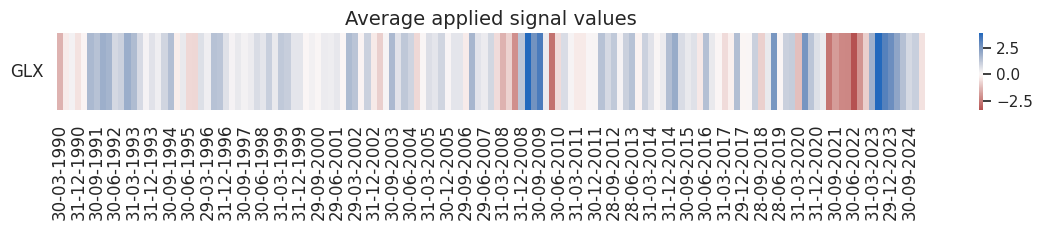

In [32]:
dix = dict_ic

pnls = dix["pnls"]
sigx = dix["sigs"]
start = dix["start"]
labels = dix["labels"]

dict_cids={
    "GLB": "Global",
    "GLX": "Global ex-U.S.",
}

pnl_labels={key + "_NEGPZN": value for key, value in labels.items()}
pnl_labels["Long only"] = "Long only"


for cid in cidx:
    pnl = pnls[f"pnls_{cid}"]
    pnl_cats = [sig + "_NEGPZN" for sig in sigx] + ["Long only"]

    pnl.plot_pnls(
        title=f"{dict_cids[cid]}: Cumulative equity basket PnLs with inflation change signals",
        title_fontsize=15,
        pnl_cats=pnl_cats,
        xcat_labels=pnl_labels,
        pnl_cids=["ALL"],
        start=start,
    )

    df_eval = pnl.evaluate_pnls(pnl_cats=pnl_cats, pnl_cids=["ALL"], start=start)[
        pnl_cats
    ]
    df_eval = df_eval.rename(columns=pnl_labels)
    display(df_eval.astype("float").round(2))

    pnl.signal_heatmap(
        pnl_name=sigx[0] + "_NEGPZN",
        pnl_cids=[cid],
        freq="q",
        start=start,
    )

### Excess inflation

#### Specs and correlation

In [33]:
labels = {
    "CPICX_SJA_P3M3ML3ARvIET": "Excess headline inflation signal",
    "CPIHX_SJA_P3M3ML3ARvIET": "Excess core inflation signal",
}


dict_xix = {
    "sigs": [key for key in labels.keys()],
    "targs": ["EQXR_NSA", "EQXR_VT10"],
    "cids": ["GLB", "GLX"],
    "start": "1990-01-01",
    "labels": labels,
    "cr": None,
    "srr": None,
    "pnls": None
}

In [34]:
dix = dict_xix

sigx = dix["sigs"]
cidx = dix["cids"]
targ = dix["targs"][0] 
start = dix["start"] 


crx = {}

# create category relation objects for each signal and frequency:

for sig in sigx:
    for cid in cidx: 
        crx[f"cr_{cid}_{sig}"] = msp.CategoryRelations(
            dfx,
            xcats=[sig, targ],
            cids=[cid],
            lag=1,
            xcat_aggs=["last", "sum"],
            start=start,
            xcat_trims=[None, None]
        )

dix["cr"] = crx

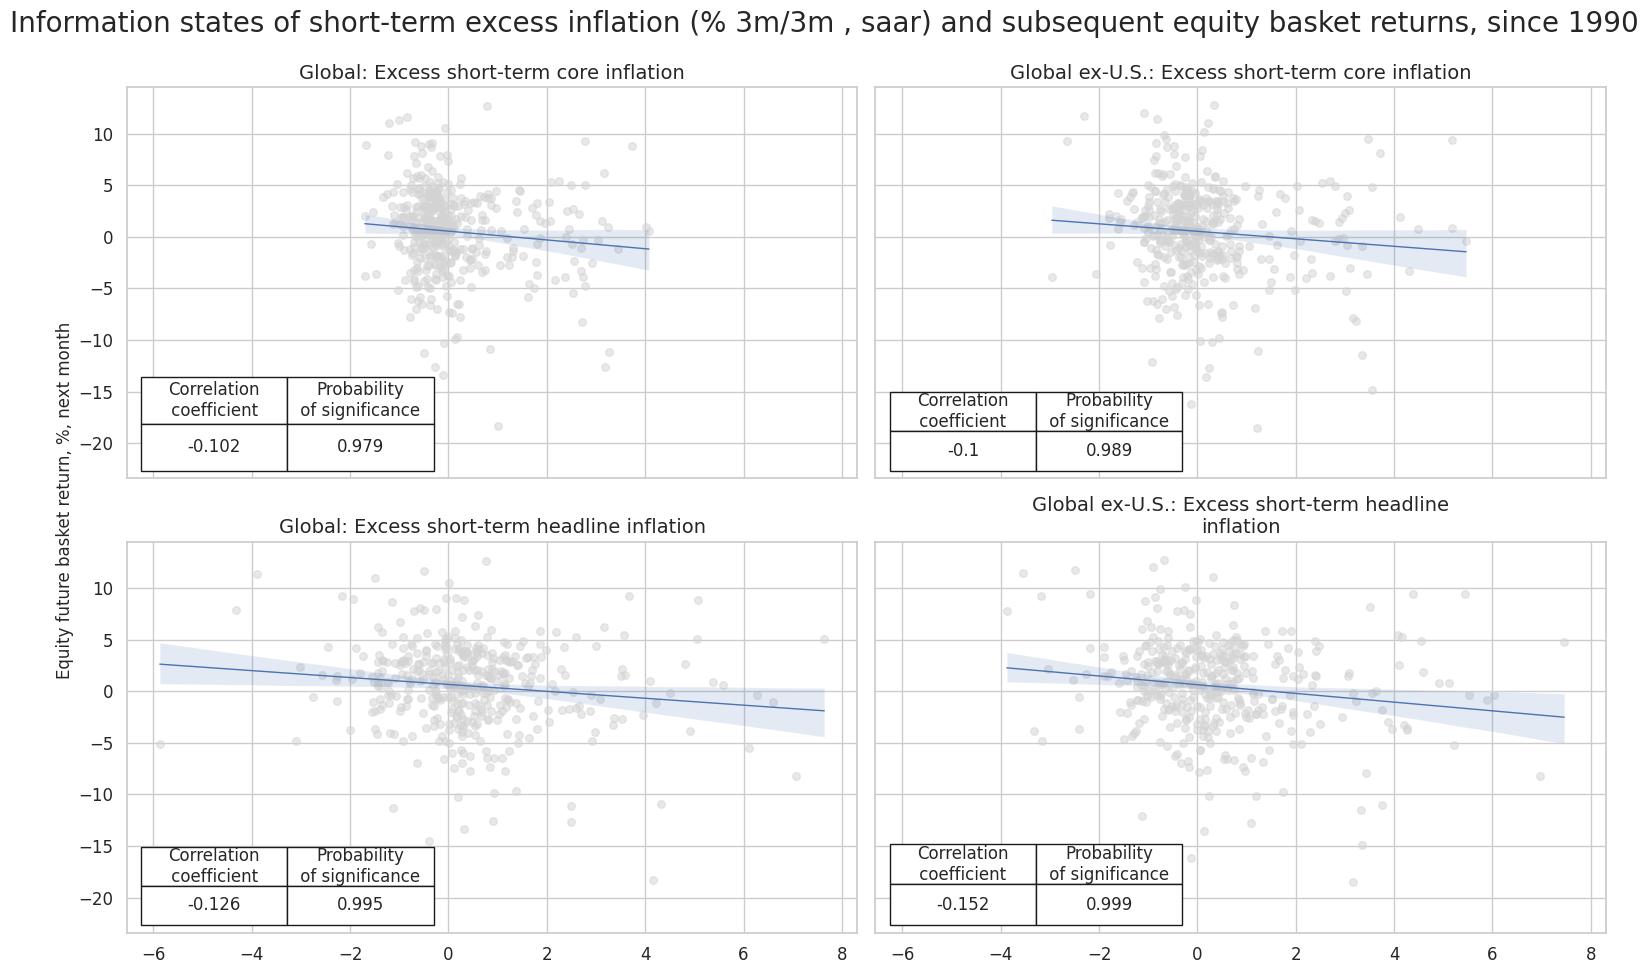

In [35]:
dix = dict_xix
crx = dix["cr"]
cidx = dix["cids"]

rels = [f"cr_{cid}_{sig}" for sig in sigx for cid in cidx]
dict_rels = {
    'cr_GLB_CPICX_SJA_P3M3ML3ARvIET': "Global: Excess short-term core inflation",
    'cr_GLB_CPIHX_SJA_P3M3ML3ARvIET': "Global: Excess short-term headline inflation",
    'cr_GLX_CPICX_SJA_P3M3ML3ARvIET': "Global ex-U.S.: Excess short-term core inflation",
    'cr_GLX_CPIHX_SJA_P3M3ML3ARvIET': "Global ex-U.S.: Excess short-term headline inflation",
}
rel_labels = [dict_rels[rel] for rel in rels]

msv.multiple_reg_scatter(
    cat_rels=[crx[rel] for rel in rels],
    title="Information states of short-term excess inflation (% 3m/3m , saar) and subsequent equity basket returns, since 1990",
    ylab="Equity future basket return, %, next month",
    ncol=2,
    nrow=len(rels) // 2,
    figsize=(16, 10),
    prob_est="map",
    coef_box="lower left",
    subplot_titles=rel_labels
)

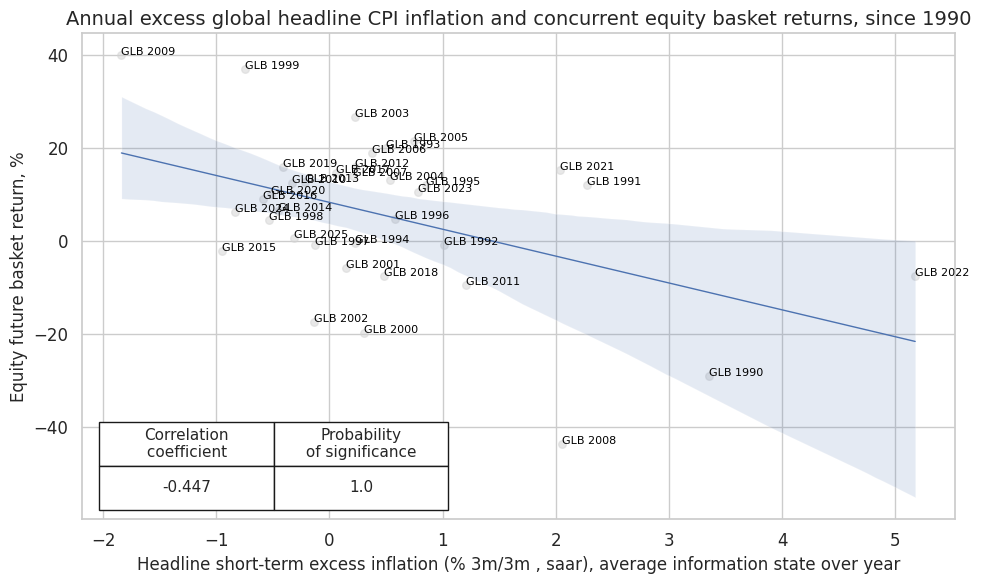

In [36]:
# Concurrent relations

dix = dict_xix
cidx = dix["cids"]
targ = dix["targs"][0] 
start = dix["start"]

sig = "CPIHX_SJA_P3M3ML3ARvIET"

cr = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=["GLB"],
    lag=0,
    xcat_aggs=["mean", "sum"],
    freq="A",
    start=start,
    xcat_trims=[None, None],
)

cr.reg_scatter( 
    labels=True,
    coef_box="lower left",
    title="Annual excess global headline CPI inflation and concurrent equity basket returns, since 1990",
    xlab="Headline short-term excess inflation (% 3m/3m , saar), average information state over year",
    ylab="Equity future basket return, %",
    prob_est="map",
    size=(10, 6),
)

#### Accuracy and correlation check

In [37]:
dix = dict_xix

sigx = dix["sigs"]
targ = dix["targs"][0]
cidx = dix["cids"]
start = dix["start"] 

srrs ={}

for cid in cidx:
    srrs[f"srr_{cid}"] = mss.SignalReturnRelations(
        dfx,
        cids=[cid],
        sigs=sigx,
        sig_neg=[True] * len(sigx),
        rets=targ,
        freqs="M",
        start=start,
    )

dix["srr"] = srrs

In [38]:
dix = dict_xix
srrs = dix["srr"]
labels = dix["labels"]

sig_labels = dict(
    zip(
        [key + "_NEG" for key in labels.keys()],
        [val + " (neg)" for val in labels.values()],
    )
)

# for column modifications
dict_cols = {
    "Signal" : "Signal",
    "accuracy": "Accuracy",
    "bal_accuracy": "Balanced accuracy",
    "pos_sigr": "Share of positive signals",
    "pos_retr": "Share of positive returns",
    "pearson": "Pearson coefficient",
    "kendall": "Kendall coefficient",
}

dict_cids={
    "GLB": "Global",
    "GLX": "Global ex-U.S.",
}

for cid in cidx:
    srr = srrs[f"srr_{cid}"]
    tbl = srr.multiple_relations_table()
    tbl = tbl.reset_index()
    tbl.rename(columns=dict_cols, inplace=True)
    tblx = tbl.set_index('Signal').drop(columns=['Return', 'Frequency', 'Aggregation', 'auc', 'pos_prec', 'neg_prec', 'pearson_pval', 'kendall_pval'])
    tblx = tblx.style.format("{:.2f}").set_caption(
    f"Predictive accuracy and correlation with respect to {dict_cids.get(cid, cid)} returns").set_table_styles(
    [{"selector": "caption", "props": [("text-align", "center"), ("font-weight", "bold"), ("font-size", "17px")]}])
    display(tblx)
    

#### Naive PnLs

In [39]:
dix = dict_xix

sigx = dix["sigs"]
targ = dix["targs"][0]
cidx = dix["cids"]
start = dix["start"]

pnls = {}

for cid in cidx:
    pnl = msn.NaivePnL(
        dfx,
        ret=targ,
        sigs=sigx,
        cids=[cid],
        start=start,
        bms=["USD_EQXR_NSA"],
    )

    for sig in sigx:
        pnl.make_pnl(
            sig,
            sig_neg=True,
            sig_op="zn_score_pan",
            sig_add = 0.5,
            rebal_freq="weekly",
            vol_scale=10,
            rebal_slip=1,
            thresh=3,
            pnl_name=sig + "_NEGPZN",
        )

    pnl.make_long_pnl(vol_scale=10, label="Long only")
    pnls[f"pnls_{cid}"] = pnl

dix["pnls"] = pnls

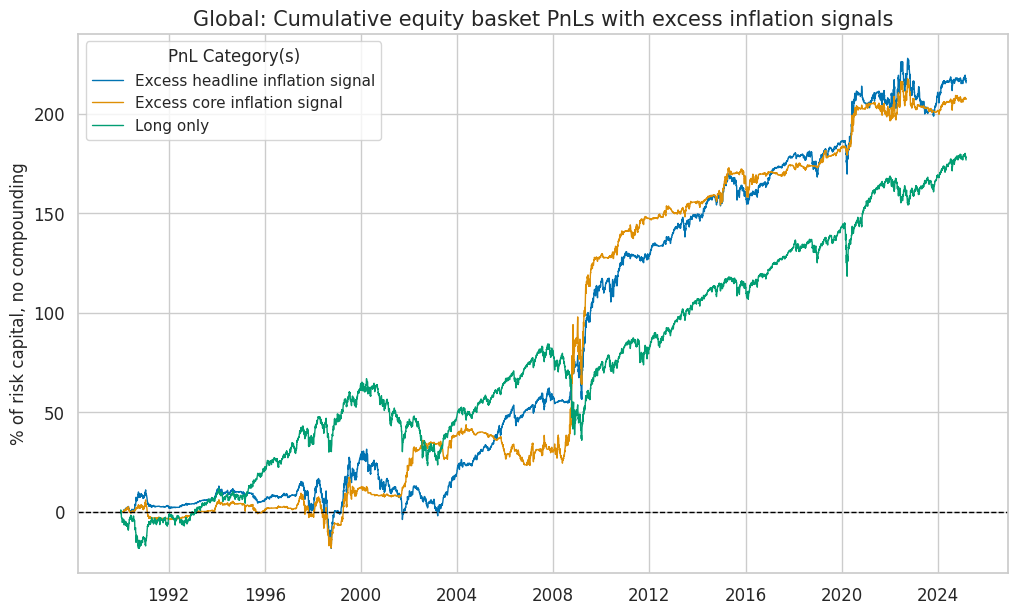

xcat                      Excess headline inflation signal  \
Return %                                              6.14   
St. Dev. %                                           10.00   
Sharpe Ratio                                          0.61   
Sortino Ratio                                         0.89   
Max 21-Day Draw %                                   -21.28   
Max 6-Month Draw %                                  -33.72   
Peak to Trough Draw %                               -35.35   
Top 5% Monthly PnL Share                              0.88   
USD_EQXR_NSA correl                                   0.27   
Traded Months                                       423.00   

xcat                      Excess core inflation signal  Long only  
Return %                                          5.90       5.03  
St. Dev. %                                       10.00      10.00  
Sharpe Ratio                                      0.59       0.50  
Sortino Ratio                                     0.89       0.70  
Max 21-Day Draw %                               -22.48     -25.76  
Max 6-Month Draw %                              -24.36     -38.71  
Peak to Trough Draw %                           -33.90     -48.48  
Top 5% Monthly PnL Share                          0.98       0.71  
USD_EQXR_NSA correl                               0.02       0.92  
Traded Months                                   423.00     423.00

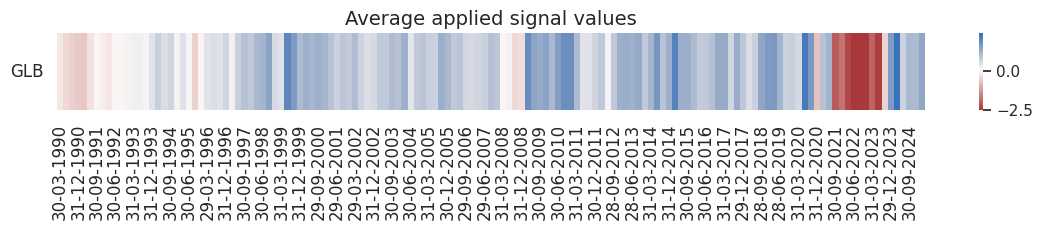

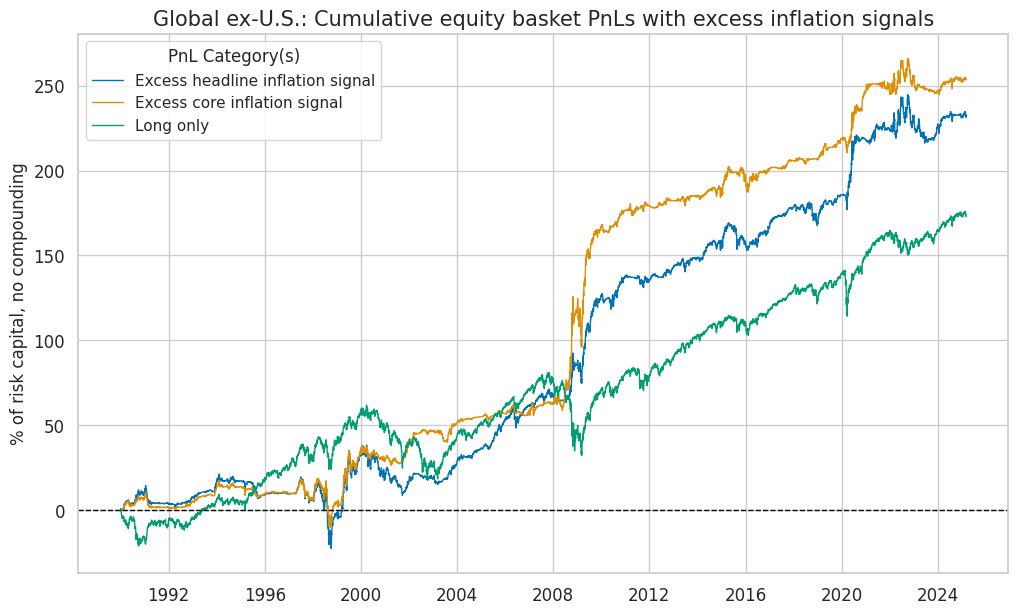

xcat                      Excess headline inflation signal  \
Return %                                              6.59   
St. Dev. %                                           10.00   
Sharpe Ratio                                          0.66   
Sortino Ratio                                         0.95   
Max 21-Day Draw %                                   -26.07   
Max 6-Month Draw %                                  -38.06   
Peak to Trough Draw %                               -43.76   
Top 5% Monthly PnL Share                              0.85   
USD_EQXR_NSA correl                                   0.21   
Traded Months                                       423.00   

xcat                      Excess core inflation signal  Long only  
Return %                                          7.23       4.91  
St. Dev. %                                       10.00      10.00  
Sharpe Ratio                                      0.72       0.49  
Sortino Ratio                                     1.09       0.68  
Max 21-Day Draw %                               -22.48     -26.00  
Max 6-Month Draw %                              -27.77     -39.12  
Peak to Trough Draw %                           -29.64     -48.75  
Top 5% Monthly PnL Share                          0.86       0.73  
USD_EQXR_NSA correl                               0.09       0.90  
Traded Months                                   423.00     423.00

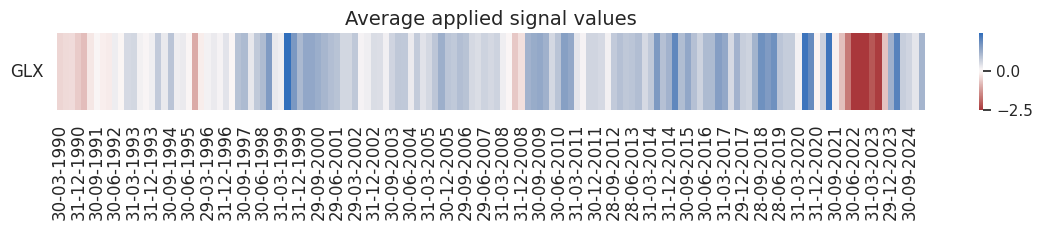

In [40]:
dix = dict_xix

pnls = dix["pnls"]
sigx = dix["sigs"]
start = dix["start"]
labels = dix["labels"]

dict_cids = {
    "GLB": "Global",
    "GLX": "Global ex-U.S.",
}

pnl_labels={key + "_NEGPZN": value for key, value in labels.items()}
pnl_labels["Long only"] = "Long only"



for cid in cidx:
    pnl = pnls[f"pnls_{cid}"]
    pnl_cats = [sig + "_NEGPZN" for sig in sigx] + ["Long only"]

    pnl.plot_pnls(
        title=f"{dict_cids[cid]}: Cumulative equity basket PnLs with excess inflation signals",
        title_fontsize=15,
        pnl_cats=pnl_cats,
        xcat_labels=pnl_labels,
        pnl_cids=["ALL"],
        start=start,
    )

    df_eval = pnl.evaluate_pnls(pnl_cats=pnl_cats, pnl_cids=["ALL"], start=start)[
        pnl_cats
    ]
    df_eval = df_eval.rename(columns=pnl_labels)

    display(df_eval.astype("float").round(2))

    pnl.signal_heatmap(
        pnl_name=sigx[0] + "_NEGPZN",
        pnl_cids=[cid],
        freq="q",
        start=start,
    )